In [1]:
# Julia 1.8.4
using Pkg
Pkg.activate(".")
Pkg.instantiate()
# Pkg.add("CUDA")
# Pkg.add("Glob")
# Pkg.add("Flux")
# Pkg.add("NIfTI")
# Pkg.add("Images")
# Pkg.add("FastAI")
# Pkg.add("Metalhead")
# Pkg.add("FastVision")
# Pkg.add("CairoMakie")
# Pkg.add("StaticArrays")
# Pkg.add("MLDataPattern")
# Pkg.add("BenchmarkTools")
# Pkg.add("ChainRulesCore")
# Pkg.add("BSON")
# Pkg.add("DataFrames")
# Pkg.add("CSV")
# Pkg.add(url = "https://github.com/Dale-Black/ComputerVisionMetrics.jl")
# Pkg.add(url="https://github.com/Dale-Black/DistanceTransforms.jl", rev="wenbo")

  Activating project at `c:\Users\wenbl13\Desktop\Wenbo_Timing`


In [2]:
using CUDA
using Glob
using Dates
using NIfTI
using Images
using Statistics
using StaticArrays
using MLDataPattern
using BenchmarkTools
using ChainRulesCore
using DistanceTransforms
using DataFrames
using CSV
using FastAI, FastVision, Flux, Metalhead
import CairoMakie; CairoMakie.activate!(type="png")
using ComputerVisionMetrics
using BSON: @save
using BSON: @load

In [3]:
# @load "test/Dice_50.bson" model1

In [4]:
# model1

In [5]:
ks = DistanceTransforms.get_GPU_kernels(Wenbo())
size(ks)

GPU threads = 768.

(11,)

# Load and prepare data

In [6]:
data_dir = raw"C:\Users\wenbl13\Desktop\Ashwin-Timing\distance-transforms\Task02_Heart"

"C:\\Users\\wenbl13\\Desktop\\Ashwin-Timing\\distance-transforms\\Task02_Heart"

In [7]:
function loadfn_label(p)
    a = NIfTI.niread(string(p)).raw
    convert_a = convert(Array{UInt8}, a)
    convert_a = convert_a .+ 1
    return convert_a
end

function loadfn_image(p)
    a = NIfTI.niread(string(p)).raw
    convert_a = convert(Array{Float32}, a)
    convert_a = convert_a / max(convert_a...)
    return convert_a
end

loadfn_image (generic function with 1 method)

In [8]:
images(dir) = mapobs(loadfn_image, Glob.glob("*.nii*", dir))
masks(dir) =  mapobs(loadfn_label, Glob.glob("*.nii*", dir))
pre_data = (
    images(joinpath(data_dir, "imagesTr")),
    masks(joinpath(data_dir, "labelsTr")),
);

In [9]:
image_size = (96, 96, 96)

(96, 96, 96)

In [10]:
function presize(files)
    container_images = Array{Float32,4}(undef, image_size..., numobs(files))
    container_masks = Array{Int64,4}(undef, image_size..., numobs(files))
    for i in 1:numobs(files)
        image, mask = FastAI.getobs(files, i)
        img = imresize(image, image_size)
        msk = round.(imresize(mask, image_size))
        container_images[:, :, :, i] = img
        container_masks[:, :, :, i] = msk
    end
    return container_images, container_masks
end

presize (generic function with 1 method)

In [11]:
img_container, mask_container = presize(pre_data)
data_resized = (img_container,mask_container);

In [12]:
a, b = FastVision.imagedatasetstats(img_container, Gray{N0f8}) 
means, stds = SVector{1, Float32}(a[1]), SVector{1, Float32}(b[1])

Progress:  10%|█████                                    |  ETA: 0:00:33

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


(Float32[0.090980366], Float32[0.13637379])

In [13]:
task = SupervisedTask(
    (FastVision.Image{3}(), Mask{3}(1:2)),
    (
        ProjectiveTransforms((image_size)),
        ImagePreprocessing(means = means, stds = stds, C = Gray{N0f8}),
        FastAI.OneHot()
    )
)

SupervisedTask(Image{3} -> Mask{3, Int64})

In [14]:
train_files, val_files = MLDataPattern.splitobs(data_resized, 0.8);

In [15]:
batch_size = 4
tdl, vdl = FastAI.taskdataloaders(train_files, val_files, task, batch_size);

In [16]:
# for (xs, ys) in tdl
#     println(size(xs))
#     println(typeof(xs))
#     println(size(ys))
#     println(typeof(ys))
#     println(minimum(ys))
#     println(maximum(ys))
#     println(typeof(maximum(ys)))
#     break
# end

Move data to gpu and pre-DT ground truth masks

In [17]:
traindl = Tuple{Tuple{CuArray{Float32, 5, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 5, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 5, CUDA.Mem.DeviceBuffer}}[] 
validdl = Tuple{Tuple{CuArray{Float32, 5, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 5, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 5, CUDA.Mem.DeviceBuffer}}[] 
for (xs, ys) in vdl
    ys_gpu = CuArray(ys[:,:,:,2:end,:])
    ys_dt_gpu = DistanceTransforms.transform(true, ys_gpu, Wenbo(), ks)
    xs_gpu = xs |> gpu
    push!(validdl, ((xs_gpu,ys_gpu), ys_dt_gpu))
end

for (xs, ys) in tdl
    ys_gpu = CuArray(ys[:,:,:,2:end,:])
    ys_dt_gpu = DistanceTransforms.transform(true, ys_gpu, Wenbo(), ks)
    xs_gpu = xs |> gpu
    push!(traindl, ((xs_gpu,ys_gpu), ys_dt_gpu))
end

┌ Warning: Number of observations less than batch-size, decreasing the batch-size to 4
└ @ MLUtils C:\Users\wenbl13\.julia\packages\MLUtils\Th9Y3\src\batchview.jl:95


# Model

In [18]:
conv = (stride, in, out) -> Conv((3, 3, 3), in=>out, stride=stride, pad=SamePad())
tran = (stride, in, out) -> ConvTranspose((3, 3, 3), in=>out, stride=stride, pad=SamePad())

conv1 = (in, out) -> Chain(conv(1, in, out), BatchNorm(out, leakyrelu))
conv2 = (in, out) -> Chain(conv(2, in, out), BatchNorm(out, leakyrelu))
conv3 = (in, out) -> Chain(conv(1, in, out), x -> softmax(x; dims = 4))
# conv3 = (in, out) -> Chain(conv(1, in, out), BatchNorm(out, sigmoid))
tran2 = (in, out) -> Chain(tran(2, in, out), BatchNorm(out, leakyrelu))



function unet3D_new(in_chs, lbl_chs)
    # Contracting layers
    l1 = Chain(conv1(in_chs, 8))
    l2 = Chain(l1, conv2(8, 16), conv1(16, 16))
    l3 = Chain(l2, conv2(16, 32), conv1(32, 32))
    l4 = Chain(l3, conv2(32, 64), conv1(64, 64))
    l5 = Chain(l4, conv2(64, 128), conv1(128, 128))

    # Expanding layers
    l6 = Chain(l5, tran2(128, 64))
    l7 = Chain(Parallel(FastVision.Models.catchannels,l4,l6), conv1(128, 64), tran2(64, 32))
    l8 = Chain(Parallel(FastVision.Models.catchannels,l3,l7), conv1(64, 32), tran2(32, 16))
    l9 = Chain(Parallel(FastVision.Models.catchannels,l2,l8), conv1(32, 16), tran2(16, 8))
    l10 = Chain(l9, conv3(8, lbl_chs))
end

unet3D_new (generic function with 1 method)

In [19]:
# model_temp = unet3D_new(1, 2)
# input_temp = rand(Float32,96,96,96,1,4)
# truth_temp = round.(rand(Float32,96,96,96,1,4))
# output_temp = model_temp(input_temp);

# Loss

In [20]:
function dice_loss(ŷ, y; ϵ=1.0f-5)
    loss_dice = 1.0f0 - (muladd(2.0f0, sum(ŷ .* y), ϵ) / (sum(ŷ .^ 2) + sum(y .^ 2) + ϵ))
    return loss_dice
end

dice_loss (generic function with 1 method)

In [21]:
function dice_hausdorff_loss(ŷ, y, y_dtm, epoch_idx; ϵ=1.0f-5)
    DTs = []
    ignore_derivatives() do
        b_s = size(ŷ)[end]
        push!(DTs, DistanceTransforms.transform(true, ŷ, Wenbo(), ks))
    end
    loss_hd = mean(((ŷ .- y) .^ 2) .* (DTs[1] .+ y_dtm))
    loss_dice = 1.0f0 - (muladd(2.0f0, sum(ŷ .* y), ϵ) / (sum(ŷ .^ 2) + sum(y .^ 2) + ϵ))
    α = epoch_idx * 1.0f-3
    loss = α * loss_hd + (1.0f0 - α) * loss_dice
    return loss
end

dice_hausdorff_loss (generic function with 1 method)

# Custom Loops

In [35]:
function train_1_epoch_with_DICE!(epoch_idx, model, model_ps, train_dl, valid_dl, optimizer)
    flush(stdout)
    println("Epoch #$epoch_idx...\n\t")
    times_per_step = [] 
    # Epoch start
    time_per_epoch = 0
    step_ct = 0
    t1 = Dates.Time(now())
    for (img_mask, mask_dtm) in train_dl
      img, mask = img_mask 
      # 96 * 96 * 96 * 1 * batch_size
      t2 = Dates.Time(now())
      curr_step_time = @timed begin
        # Step start
        gs = gradient(model_ps) do
          pred_mask = model(img)
          training_loss = dice_loss(pred_mask[:,:,:,2:end,:], mask)
          return training_loss
        end
        Flux.update!(optimizer, model_ps, gs)
      end
      # Step finished
      push!(times_per_step, (curr_step_time.time * 10^9)+(t2-t1).value)
      time_per_epoch += curr_step_time.time * 10^9 + (t2-t1).value # t2 - t1 is the loading time from dataloader
      step_ct += 1
      t1 = Dates.Time(now())
    end
    # Epoch finished
    # Train set loss
    train_losses = []
    train_dice_metrics = []
    train_hd_metrics = []
    for (img_mask, mask_dtm) in train_dl
      img, mask = img_mask 
      pred_mask = model(img)
      training_loss = dice_loss(pred_mask[:,:,:,2:end,:], mask)
      push!(train_losses, training_loss)
      pred_mask_bi_1 = pred_mask[:,:,:,2,1] .> 0.5
      mask_bi_1 = mask[:,:,:,1,1] .> 0.5
      pred_mask_bi = pred_mask_bi_1 |> cpu
      mask_bi = mask_bi_1 |> cpu
      dice_m = ComputerVisionMetrics.dice(pred_mask_bi, mask_bi)
      hd_m = ComputerVisionMetrics.hausdorff(pred_mask_bi, mask_bi)
      push!(train_dice_metrics, dice_m)
      push!(train_hd_metrics, hd_m)
    end
    # Valid set loss
    valid_losses = []
    valid_dice_metrics = []
    valid_hd_metrics = []
    for (img_mask, mask_dtm) in valid_dl
      img, mask = img_mask 
      pred_mask = model(img)
      valid_loss = dice_loss(pred_mask[:,:,:,2:end,:], mask)
      push!(valid_losses, valid_loss)
      pred_mask_bi_1 = pred_mask[:,:,:,2,1] .> 0.5
      mask_bi_1 = mask[:,:,:,1,1] .> 0.5
      pred_mask_bi = pred_mask_bi_1 |> cpu
      mask_bi = mask_bi_1 |> cpu
      dice_m2 = ComputerVisionMetrics.dice(pred_mask_bi, mask_bi)
      hd_m2 = ComputerVisionMetrics.hausdorff(pred_mask_bi, mask_bi)
      push!(valid_dice_metrics, dice_m2)
      push!(valid_hd_metrics, hd_m2)
    end
    println("\tFinished $step_ct steps --> Train loss = $(mean(train_losses)), Valid loss = $(mean(valid_losses)), 
    Dice = $(mean(valid_dice_metrics)), HD = $(mean(valid_hd_metrics))")
    return time_per_epoch, times_per_step, mean(train_losses), mean(valid_losses), mean(train_dice_metrics), 
    mean(train_hd_metrics), mean([mean(train_dice_metrics), mean(valid_dice_metrics)]), mean(valid_dice_metrics), 
    mean(valid_hd_metrics), mean([mean(train_hd_metrics), mean(valid_hd_metrics)])
  end

train_1_epoch_with_DICE! (generic function with 1 method)

In [34]:
function train_1_epoch_with_DICE_and_HD!(epoch_idx, model, model_ps, train_dl, valid_dl, optimizer)
    ep_idx = Float32(epoch_idx)
    flush(stdout)
    println("Epoch #$epoch_idx...")
    times_per_step = [] 
    # Epoch start (4 outputs)
    time_per_epoch = 0
    step_ct = 0
    t1 = Dates.Time(now())
    for (img_mask, mask_dtm) in train_dl
      img, mask = img_mask 
      t2 = Dates.Time(now())
      # print("Step $step_ct --> ")
      curr_step_time = @timed begin
        # Step start
        gs = gradient(model_ps) do
          pred_mask = model(img)
          training_loss = dice_hausdorff_loss(pred_mask[:,:,:,2:end,:], mask, mask_dtm, ep_idx)
          # println("loss = $training_loss")
          return training_loss
        end
        Flux.update!(optimizer, model_ps, gs)
      end
      # Step finished
      push!(times_per_step, (curr_step_time.time * 10^9)+(t2-t1).value)
      time_per_epoch += curr_step_time.time * 10^9 + (t2-t1).value # t2 - t1 is the loading time from dataloader
      step_ct += 1
      t1 = Dates.Time(now())
    end
    # Epoch finished
    # Train set loss (4 outputs)
    train_losses = []
    train_dice_metrics = []
    train_hd_metrics = []
    for (img_mask, mask_dtm) in train_dl
      img, mask = img_mask 
      pred_mask = model(img)
      training_loss = dice_hausdorff_loss(pred_mask[:,:,:,2:end,:], mask, mask_dtm, ep_idx)
      push!(train_losses, training_loss)
      pred_mask_bi_1 = pred_mask[:,:,:,2,1] .> 0.5
      mask_bi_1 = mask[:,:,:,1,1] .> 0.5
      pred_mask_bi = pred_mask_bi_1 |> cpu
      mask_bi = mask_bi_1 |> cpu
      dice_m = ComputerVisionMetrics.dice(pred_mask_bi, mask_bi)
      hd_m = ComputerVisionMetrics.hausdorff(pred_mask_bi, mask_bi)
      push!(train_dice_metrics, dice_m)
      push!(train_hd_metrics, hd_m)
    end
    # Valid set loss (1 outputs)
    valid_losses = []
    valid_dice_metrics = []
    valid_hd_metrics = []
    for (img_mask, mask_dtm) in valid_dl
      img, mask = img_mask 
      pred_mask = model(img)
      valid_loss = dice_hausdorff_loss(pred_mask[:,:,:,2:end,:], mask, mask_dtm, ep_idx)
      push!(valid_losses, valid_loss)
      pred_mask_bi_1 = pred_mask[:,:,:,2,1] .> 0.5
      mask_bi_1 = mask[:,:,:,1,1] .> 0.5
      pred_mask_bi = pred_mask_bi_1 |> cpu
      mask_bi = mask_bi_1 |> cpu
      dice_m2 = ComputerVisionMetrics.dice(pred_mask_bi, mask_bi)
      hd_m2 = ComputerVisionMetrics.hausdorff(pred_mask_bi, mask_bi)
      push!(valid_dice_metrics, dice_m2)
      push!(valid_hd_metrics, hd_m2)
    end
    println("\tFinished $step_ct steps --> Train loss = $(mean(train_losses)), Valid loss = $(mean(valid_losses)), 
    Dice = $(mean(valid_dice_metrics)), HD = $(mean(valid_hd_metrics))")
    return time_per_epoch, times_per_step, mean(train_losses), mean(valid_losses), mean(train_dice_metrics), 
    mean(train_hd_metrics), mean([mean(train_dice_metrics), mean(valid_dice_metrics)]), mean(valid_dice_metrics), 
    mean(valid_hd_metrics), mean([mean(train_hd_metrics), mean(valid_hd_metrics)])
  end

train_1_epoch_with_DICE_and_HD! (generic function with 1 method)

# Train, Loss = Dice

In [44]:
num_epochs_dice = 250
epoch_times_dice = []
step_times_dice = []
epoch_train_losses_dice = []
epoch_valid_losses_dice = []
train_dice_metric_epoch_dice = []
valid_dice_metric_epoch_dice = []
train_hd_metric_epoch_dice = []
valid_hd_metric_epoch_dice = []
all_dice_metric_epoch_dice = []
all_hd_metric_epoch_dice = []
model1 = unet3D_new(1, 2) |> gpu
model_ps = Flux.params(model1)
optimizer = Adam() 
for epoch_idx = 1:num_epochs_dice
    curr_time_epoch, curr_times_step, curr_train_losses, curr_valid_losses, curr_train_dice, curr_train_hd, curr_all_dice, 
    curr_valid_dice, curr_valid_hd, curr_all_hd = train_1_epoch_with_DICE!(epoch_idx, model1, model_ps, traindl, validdl, optimizer)
    # Record data
    push!(epoch_times_dice, curr_time_epoch)
    for i in curr_times_step
        push!(step_times_dice, i)
    end
    push!(epoch_train_losses_dice, curr_train_losses)
    push!(epoch_valid_losses_dice, curr_valid_losses)
    push!(train_dice_metric_epoch_dice, curr_train_dice)
    push!(valid_dice_metric_epoch_dice, curr_valid_dice)
    push!(train_hd_metric_epoch_dice, curr_train_hd)
    push!(valid_hd_metric_epoch_dice, curr_valid_hd)
    push!(all_dice_metric_epoch_dice, curr_all_dice)
    push!(all_hd_metric_epoch_dice, curr_all_hd)
    if epoch_idx % 25 == 0
        #save model
        savetaskmodel(string("savedmodels/Dice_", epoch_idx, ".jld2"), task, model1, force = true) # saving as cpu model
    end
end

Epoch #1...
	


	Finished 4 steps --> Train loss = 0.9769528, Valid loss = 0.9785426, 
    Dice = 0.017548743477216654, HD = 77.31106001084191


Epoch #2...
	


	Finished 4 steps --> Train loss = 0.9751758, Valid loss = 0.9768351, 
    Dice = 0.019328825185975416, HD = 76.08547824650904


Epoch #3...
	


	Finished 4 steps --> Train loss = 0.96870035, Valid loss = 0.9708064, 
    Dice = 0.0253198032445012, HD = 68.65857557508748


Epoch #4...
	


	Finished 4 steps --> Train loss = 0.9430659, Valid loss = 0.946258, 
    Dice = 0.18997452119893504, HD = 46.06517122512408


Epoch #5...
	


	Finished 4 steps --> Train loss = 0.90940833, Valid loss = 0.9117977, 
    Dice = 0.37679769894535, HD = 25.03996805109783


Epoch #6...
	


	Finished 4 steps --> Train loss = 0.84028673, Valid loss = 0.8469685, 
    Dice = 0.4156645874863353, HD = 21.6794833886788


Epoch #7...
	


	Finished 4 steps --> Train loss = 0.81525964, Valid loss = 0.81897163, 
    Dice = 0.5838128116609129, HD = 16.64331697709324


Epoch #8...
	


	Finished 4 steps --> Train loss = 0.6065345, Valid loss = 0.60607266, 
    Dice = 0.47977643771142814, HD = 17.60681686165901


Epoch #9...
	


	Finished 4 steps --> Train loss = 0.73756444, Valid loss = 0.717815, 
    Dice = 0.22666316066263476, HD = 24.351591323771842


Epoch #10...
	


	Finished 4 steps --> Train loss = 0.34745044, Valid loss = 0.32159436, 
    Dice = 0.7362022076467765, HD = 13.0


Epoch #11...
	


	Finished 4 steps --> Train loss = 0.24258061, Valid loss = 0.25678408, 
    Dice = 0.7237578429710022, HD = 12.68857754044952


Epoch #12...
	


	Finished 4 steps --> Train loss = 0.25286177, Valid loss = 0.25855803, 
    Dice = 0.7043803653973145, HD = 7.0710678118654755


Epoch #13...
	


	Finished 4 steps --> Train loss = 0.37423182, Valid loss = 0.37259406, 
    Dice = 0.5866885784716516, HD = 18.439088914585774


Epoch #14...
	


	Finished 4 steps --> Train loss = 0.15974866, Valid loss = 0.18409622, 
    Dice = 0.7279800809212574, HD = 10.816653826391969


Epoch #15...
	


	Finished 4 steps --> Train loss = 0.16537148, Valid loss = 0.16561985, 
    Dice = 0.8045867176301958, HD = 9.0


Epoch #16...
	


	Finished 4 steps --> Train loss = 0.1406667, Valid loss = 0.16823316, 
    Dice = 0.8152828802351212, HD = 8.774964387392123


Epoch #17...
	


	Finished 4 steps --> Train loss = 0.22969383, Valid loss = 0.25305933, 
    Dice = 0.6226452508427524, HD = 11.445523142259598


Epoch #18...
	


	Finished 4 steps --> Train loss = 0.1652275, Valid loss = 0.19984972, 
    Dice = 0.7574365175332527, HD = 7.0


Epoch #19...
	


	Finished 4 steps --> Train loss = 0.13614571, Valid loss = 0.17256129, 
    Dice = 0.8056382145653876, HD = 8.774964387392123


Epoch #20...
	


	Finished 4 steps --> Train loss = 0.11041401, Valid loss = 0.15855408, 
    Dice = 0.8151510852603207, HD = 7.54983443527075


Epoch #21...
	


	Finished 4 steps --> Train loss = 0.1414762, Valid loss = 0.18268275, 
    Dice = 0.6661085063630274, HD = 8.774964387392123


Epoch #22...
	


	Finished 4 steps --> Train loss = 0.10531263, Valid loss = 0.1492899, 
    Dice = 0.823580282502162, HD = 7.54983443527075


Epoch #23...
	


	Finished 4 steps --> Train loss = 0.10434522, Valid loss = 0.15105891, 
    Dice = 0.8111759287688056, HD = 8.06225774829855


Epoch #24...
	


	Finished 4 steps --> Train loss = 0.10916823, Valid loss = 0.15391928, 
    Dice = 0.8074500136948781, HD = 7.54983443527075


Epoch #25...
	


	Finished 4 steps --> Train loss = 0.097144976, Valid loss = 0.15271902, 
    Dice = 0.8040816326530612, HD = 8.06225774829855


Epoch #26...
	


	Finished 4 steps --> Train loss = 0.08659837, Valid loss = 0.14190227, 
    Dice = 0.7928907168037603, HD = 8.06225774829855


Epoch #27...
	


	Finished 4 steps --> Train loss = 0.08318703, Valid loss = 0.13775462, 
    Dice = 0.8218322427126711, HD = 7.54983443527075


Epoch #28...
	


	Finished 4 steps --> Train loss = 0.120189235, Valid loss = 0.1652506, 
    Dice = 0.7797120857047205, HD = 8.06225774829855


Epoch #29...
	


	Finished 4 steps --> Train loss = 0.091726795, Valid loss = 0.13001508, 
    Dice = 0.8232206268334106, HD = 7.681145747868608


Epoch #30...
	


	Finished 4 steps --> Train loss = 0.09467064, Valid loss = 0.1647656, 
    Dice = 0.7894073139974779, HD = 8.306623862918075


Epoch #31...
	


	Finished 4 steps --> Train loss = 0.08937852, Valid loss = 0.15792477, 
    Dice = 0.8074980058495081, HD = 8.306623862918075


Epoch #32...
	


	Finished 4 steps --> Train loss = 0.08539282, Valid loss = 0.13514286, 
    Dice = 0.8301939836941242, HD = 7.54983443527075


Epoch #33...
	


	Finished 4 steps --> Train loss = 0.08068851, Valid loss = 0.1430198, 
    Dice = 0.7977110157367668, HD = 8.06225774829855


Epoch #34...
	


	Finished 4 steps --> Train loss = 0.07562497, Valid loss = 0.120670974, 
    Dice = 0.8379724582478758, HD = 7.54983443527075


Epoch #35...
	


	Finished 4 steps --> Train loss = 0.10353951, Valid loss = 0.15874678, 
    Dice = 0.7828636585763153, HD = 8.06225774829855


Epoch #36...
	


	Finished 4 steps --> Train loss = 0.07374002, Valid loss = 0.12772101, 
    Dice = 0.8052672347017815, HD = 8.06225774829855


Epoch #37...
	


	Finished 4 steps --> Train loss = 0.0650264, Valid loss = 0.13487172, 
    Dice = 0.801056338028169, HD = 8.06225774829855


Epoch #38...
	


	Finished 4 steps --> Train loss = 0.0884376, Valid loss = 0.14360231, 
    Dice = 0.8260197775030902, HD = 8.06225774829855


Epoch #39...
	


	Finished 4 steps --> Train loss = 0.0818557, Valid loss = 0.13416588, 
    Dice = 0.8067333650944895, HD = 8.12403840463596


Epoch #40...
	


	Finished 4 steps --> Train loss = 0.06871386, Valid loss = 0.136105, 
    Dice = 0.7899461400359067, HD = 8.306623862918075


Epoch #41...
	


	Finished 4 steps --> Train loss = 0.0678837, Valid loss = 0.13601571, 
    Dice = 0.8288995493531036, HD = 8.06225774829855


Epoch #42...
	


	Finished 4 steps --> Train loss = 0.06495936, Valid loss = 0.12306303, 
    Dice = 0.8251094009355666, HD = 8.06225774829855


Epoch #43...
	


	Finished 4 steps --> Train loss = 0.07396589, Valid loss = 0.1414969, 
    Dice = 0.7948555096856145, HD = 8.12403840463596


Epoch #44...
	


	Finished 4 steps --> Train loss = 0.06788431, Valid loss = 0.13377959, 
    Dice = 0.8359050445103857, HD = 8.06225774829855


Epoch #45...
	


	Finished 4 steps --> Train loss = 0.062573165, Valid loss = 0.12951672, 
    Dice = 0.8116408306522375, HD = 8.306623862918075


Epoch #46...
	


	Finished 4 steps --> Train loss = 0.05882974, Valid loss = 0.13054836, 
    Dice = 0.8228606544784145, HD = 8.06225774829855


Epoch #47...
	


	Finished 4 steps --> Train loss = 0.053747147, Valid loss = 0.12651646, 
    Dice = 0.8403118683222639, HD = 7.54983443527075


Epoch #48...
	


	Finished 4 steps --> Train loss = 0.061848834, Valid loss = 0.13414204, 
    Dice = 0.8039246223329699, HD = 8.06225774829855


Epoch #49...
	


	Finished 4 steps --> Train loss = 0.08737902, Valid loss = 0.15008438, 
    Dice = 0.8085867620751341, HD = 8.246211251235321


Epoch #50...
	


	Finished 4 steps --> Train loss = 0.07270475, Valid loss = 0.13641512, 
    Dice = 0.7974317817014446, HD = 8.12403840463596

Epoch #51...
	


	Finished 4 steps --> Train loss = 0.049626708, Valid loss = 0.13530064, 
    Dice = 0.8327319959590128, HD = 8.306623862918075


Epoch #52...
	


	Finished 4 steps --> Train loss = 0.14462648, Valid loss = 0.22099274, 
    Dice = 0.747361174850849, HD = 7.280109889280518


Epoch #53...
	


	Finished 4 steps --> Train loss = 0.04730709, Valid loss = 0.12849844, 
    Dice = 0.8362168396770473, HD = 8.06225774829855


Epoch #54...
	


	Finished 4 steps --> Train loss = 0.05531004, Valid loss = 0.12538481, 
    Dice = 0.8279767370676462, HD = 7.681145747868608


Epoch #55...
	


	Finished 4 steps --> Train loss = 0.0480697, Valid loss = 0.123579085, 
    Dice = 0.8255456276548997, HD = 7.54983443527075


Epoch #56...
	


	Finished 4 steps --> Train loss = 0.07139346, Valid loss = 0.13622922, 
    Dice = 0.8330170777988615, HD = 8.06225774829855


Epoch #57...
	


	Finished 4 steps --> Train loss = 0.04401505, Valid loss = 0.114362, 
    Dice = 0.844009922661608, HD = 5.196152422706632


Epoch #58...
	


	Finished 4 steps --> Train loss = 0.055382907, Valid loss = 0.1326701, 
    Dice = 0.8237844533911428, HD = 8.12403840463596


Epoch #59...
	


	Finished 4 steps --> Train loss = 0.052633062, Valid loss = 0.12399274, 
    Dice = 0.844964730601831, HD = 8.06225774829855


Epoch #60...
	


	Finished 4 steps --> Train loss = 0.04186052, Valid loss = 0.11845827, 
    Dice = 0.836937463471654, HD = 8.12403840463596


Epoch #61...
	


	Finished 4 steps --> Train loss = 0.043164, Valid loss = 0.12421566, 
    Dice = 0.8343834383438344, HD = 8.06225774829855


Epoch #62...
	


	Finished 4 steps --> Train loss = 0.037765652, Valid loss = 0.12061936, 
    Dice = 0.8367317001613613, HD = 8.06225774829855


Epoch #63...
	


	Finished 4 steps --> Train loss = 0.040497303, Valid loss = 0.117841244, 
    Dice = 0.8463132958246965, HD = 8.06225774829855


Epoch #64...
	


	Finished 4 steps --> Train loss = 0.051736042, Valid loss = 0.12392038, 
    Dice = 0.8396617986164489, HD = 8.06225774829855


Epoch #65...
	


	Finished 4 steps --> Train loss = 0.035068497, Valid loss = 0.12041265, 
    Dice = 0.8334794040315513, HD = 8.12403840463596


Epoch #66...
	


	Finished 4 steps --> Train loss = 0.04720147, Valid loss = 0.13549054, 
    Dice = 0.8270696803530828, HD = 6.928203230275509


Epoch #67...
	


	Finished 4 steps --> Train loss = 0.040977493, Valid loss = 0.12213457, 
    Dice = 0.8349660889223813, HD = 8.246211251235321


Epoch #68...
	


	Finished 4 steps --> Train loss = 0.033109516, Valid loss = 0.11686212, 
    Dice = 0.8437956204379562, HD = 6.928203230275509


Epoch #69...
	


	Finished 4 steps --> Train loss = 0.036000848, Valid loss = 0.126441, 
    Dice = 0.8310565932534151, HD = 8.12403840463596


Epoch #70...
	


	Finished 4 steps --> Train loss = 0.044434324, Valid loss = 0.1192587, 
    Dice = 0.8461074230537116, HD = 5.196152422706632


Epoch #71...
	


	Finished 4 steps --> Train loss = 0.03261803, Valid loss = 0.116785586, 
    Dice = 0.8361058874584116, HD = 6.928203230275509


Epoch #72...
	


	Finished 4 steps --> Train loss = 0.034603328, Valid loss = 0.117788434, 
    Dice = 0.8398576512455516, HD = 8.12403840463596


Epoch #73...
	


	Finished 4 steps --> Train loss = 0.041096717, Valid loss = 0.12884402, 
    Dice = 0.8303423314733825, HD = 8.246211251235321


Epoch #74...
	


	Finished 4 steps --> Train loss = 0.039349973, Valid loss = 0.11544973, 
    Dice = 0.847630473905219, HD = 8.12403840463596


Epoch #75...
	


	Finished 4 steps --> Train loss = 0.031535476, Valid loss = 0.11952025, 
    Dice = 0.8376189799687456, HD = 6.928203230275509


Epoch #76...
	


	Finished 4 steps --> Train loss = 0.027969852, Valid loss = 0.1219061, 
    Dice = 0.8363065505922649, HD = 8.12403840463596


Epoch #77...
	


	Finished 4 steps --> Train loss = 0.045825616, Valid loss = 0.11945754, 
    Dice = 0.848816029143898, HD = 8.12403840463596


Epoch #78...
	


	Finished 4 steps --> Train loss = 0.030486807, Valid loss = 0.123185754, 
    Dice = 0.8411582794489738, HD = 6.928203230275509


Epoch #79...
	


	Finished 4 steps --> Train loss = 0.0277033, Valid loss = 0.122311056, 
    Dice = 0.835820895522388, HD = 8.12403840463596


Epoch #80...
	


	Finished 4 steps --> Train loss = 0.050096065, Valid loss = 0.12633151, 
    Dice = 0.8357231920199502, HD = 8.12403840463596


Epoch #81...
	


	Finished 4 steps --> Train loss = 0.027099773, Valid loss = 0.12150538, 
    Dice = 0.8400727578004757, HD = 6.928203230275509


Epoch #82...
	


	Finished 4 steps --> Train loss = 0.023746505, Valid loss = 0.117370605, 
    Dice = 0.8379038047379755, HD = 8.06225774829855


Epoch #83...
	


	Finished 4 steps --> Train loss = 0.040788203, Valid loss = 0.12218386, 
    Dice = 0.8362187835146315, HD = 8.246211251235321


Epoch #84...
	


	Finished 4 steps --> Train loss = 0.022359625, Valid loss = 0.119276226, 
    Dice = 0.8399772209567198, HD = 8.12403840463596


Epoch #85...
	


	Finished 4 steps --> Train loss = 0.023783475, Valid loss = 0.11406118, 
    Dice = 0.8422876949740035, HD = 8.12403840463596


Epoch #86...
	


	Finished 4 steps --> Train loss = 0.02574341, Valid loss = 0.116758645, 
    Dice = 0.8432480666270077, HD = 8.12403840463596


Epoch #87...
	


	Finished 4 steps --> Train loss = 0.026912734, Valid loss = 0.122599065, 
    Dice = 0.8439716312056738, HD = 8.12403840463596


Epoch #88...
	


	Finished 4 steps --> Train loss = 0.029125452, Valid loss = 0.1176126, 
    Dice = 0.8436435868331441, HD = 6.928203230275509


Epoch #89...
	


	Finished 4 steps --> Train loss = 0.025951385, Valid loss = 0.119306326, 
    Dice = 0.8378536016331292, HD = 8.246211251235321


Epoch #90...
	


	Finished 4 steps --> Train loss = 0.027065873, Valid loss = 0.116045356, 
    Dice = 0.8417588991923423, HD = 6.928203230275509


Epoch #91...
	


	Finished 4 steps --> Train loss = 0.024255678, Valid loss = 0.11705041, 
    Dice = 0.8436681222707424, HD = 6.928203230275509


Epoch #92...
	


	Finished 4 steps --> Train loss = 0.026463285, Valid loss = 0.12138361, 
    Dice = 0.8457008244994111, HD = 8.12403840463596


Epoch #93...
	


	Finished 4 steps --> Train loss = 0.02638805, Valid loss = 0.113731265, 
    Dice = 0.8478229212174166, HD = 5.385164807134504


Epoch #94...
	


	Finished 4 steps --> Train loss = 0.023015797, Valid loss = 0.12134004, 
    Dice = 0.8396708286038592, HD = 7.483314773547883


Epoch #95...
	


	Finished 4 steps --> Train loss = 0.029307976, Valid loss = 0.11979622, 
    Dice = 0.8438298511949497, HD = 8.06225774829855


Epoch #96...
	


	Finished 4 steps --> Train loss = 0.023965314, Valid loss = 0.11539137, 
    Dice = 0.8561362301820317, HD = 14.560219778561036


Epoch #97...
	


	Finished 4 steps --> Train loss = 0.019681484, Valid loss = 0.11829746, 
    Dice = 0.8333333333333334, HD = 8.246211251235321


Epoch #98...
	


	Finished 4 steps --> Train loss = 0.019607082, Valid loss = 0.11676127, 
    Dice = 0.8481012658227848, HD = 6.928203230275509


Epoch #99...
	


	Finished 4 steps --> Train loss = 0.032455683, Valid loss = 0.119330704, 
    Dice = 0.8451173353520061, HD = 8.12403840463596


Epoch #100...
	


	Finished 4 steps --> Train loss = 0.021451041, Valid loss = 0.113628745, 
    Dice = 0.8450620934358368, HD = 6.928203230275509


Epoch #101...
	


	Finished 4 steps --> Train loss = 0.021653444, Valid loss = 0.12372935, 
    Dice = 0.8374301675977653, HD = 7.483314773547883


Epoch #102...
	


	Finished 4 steps --> Train loss = 0.025495932, Valid loss = 0.11518085, 
    Dice = 0.8501711054902544, HD = 6.928203230275509


Epoch #103...
	


	Finished 4 steps --> Train loss = 0.019346118, Valid loss = 0.114592254, 
    Dice = 0.8522660388463802, HD = 6.928203230275509


Epoch #104...
	


	Finished 4 steps --> Train loss = 0.018891111, Valid loss = 0.12113762, 
    Dice = 0.8336644904910587, HD = 8.246211251235321


Epoch #105...
	


	Finished 4 steps --> Train loss = 0.018686384, Valid loss = 0.11424464, 
    Dice = 0.8508093918623305, HD = 6.928203230275509


Epoch #106...
	


	Finished 4 steps --> Train loss = 0.020445302, Valid loss = 0.11570811, 
    Dice = 0.8519994097683341, HD = 6.928203230275509


Epoch #107...
	


	Finished 4 steps --> Train loss = 0.016783789, Valid loss = 0.11891228, 
    Dice = 0.8385689354275742, HD = 6.928203230275509


Epoch #108...
	


	Finished 4 steps --> Train loss = 0.0150010735, Valid loss = 0.114885926, 
    Dice = 0.8490401396160558, HD = 6.928203230275509


Epoch #109...
	


	Finished 4 steps --> Train loss = 0.020974636, Valid loss = 0.11380327, 
    Dice = 0.8486734845116348, HD = 6.928203230275509


Epoch #110...
	


	Finished 4 steps --> Train loss = 0.017950267, Valid loss = 0.12049776, 
    Dice = 0.8407182160440196, HD = 6.928203230275509


Epoch #111...
	


	Finished 4 steps --> Train loss = 0.018154696, Valid loss = 0.12344968, 
    Dice = 0.8385032688830157, HD = 6.928203230275509


Epoch #112...
	


	Finished 4 steps --> Train loss = 0.02124463, Valid loss = 0.11291915, 
    Dice = 0.8494670754854723, HD = 14.560219778561036


Epoch #113...
	


	Finished 4 steps --> Train loss = 0.02170211, Valid loss = 0.12346393, 
    Dice = 0.8400234397890419, HD = 7.483314773547883


Epoch #114...
	


	Finished 4 steps --> Train loss = 0.015894562, Valid loss = 0.11514205, 
    Dice = 0.8373642288196959, HD = 8.246211251235321


Epoch #115...
	


	Finished 4 steps --> Train loss = 0.014871597, Valid loss = 0.114435256, 
    Dice = 0.8536196141012622, HD = 6.928203230275509


Epoch #116...
	


	Finished 4 steps --> Train loss = 0.015319526, Valid loss = 0.11688399, 
    Dice = 0.8417078129538194, HD = 14.560219778561036


Epoch #117...
	


	Finished 4 steps --> Train loss = 0.0133353025, Valid loss = 0.11502671, 
    Dice = 0.8447062203706364, HD = 6.928203230275509


Epoch #118...
	


	Finished 4 steps --> Train loss = 0.013550475, Valid loss = 0.11837119, 
    Dice = 0.8465532160369196, HD = 6.928203230275509


Epoch #119...
	


	Finished 4 steps --> Train loss = 0.014504686, Valid loss = 0.11587441, 
    Dice = 0.8457292271934922, HD = 14.560219778561036


Epoch #120...
	


	Finished 4 steps --> Train loss = 0.01404801, Valid loss = 0.11706883, 
    Dice = 0.844724132884531, HD = 5.385164807134504


Epoch #121...
	


	Finished 4 steps --> Train loss = 0.013672903, Valid loss = 0.12266511, 
    Dice = 0.8398316970546985, HD = 7.483314773547883


Epoch #122...
	


	Finished 4 steps --> Train loss = 0.012296051, Valid loss = 0.120764256, 
    Dice = 0.841941857183178, HD = 6.928203230275509


Epoch #123...
	


	Finished 4 steps --> Train loss = 0.03583829, Valid loss = 0.1234712, 
    Dice = 0.8496852448948258, HD = 4.58257569495584


Epoch #124...
	


	Finished 4 steps --> Train loss = 0.013272032, Valid loss = 0.118484855, 
    Dice = 0.8404658341518171, HD = 14.560219778561036


Epoch #125...
	


	Finished 4 steps --> Train loss = 0.025866851, Valid loss = 0.1308127, 
    Dice = 0.8272499303427139, HD = 6.928203230275509


Epoch #126...
	


	Finished 4 steps --> Train loss = 0.033955395, Valid loss = 0.12420565, 
    Dice = 0.8425911678719803, HD = 5.477225575051661


Epoch #127...
	


	Finished 4 steps --> Train loss = 0.021423683, Valid loss = 0.13204074, 
    Dice = 0.8377645143787303, HD = 14.560219778561036


Epoch #128...
	


	Finished 4 steps --> Train loss = 0.023066744, Valid loss = 0.12709534, 
    Dice = 0.8301945044766903, HD = 8.366600265340756


Epoch #129...
	


	Finished 4 steps --> Train loss = 0.034319803, Valid loss = 0.12897289, 
    Dice = 0.8294377763739734, HD = 6.4031242374328485


Epoch #130...
	


	Finished 4 steps --> Train loss = 0.015335232, Valid loss = 0.12311262, 
    Dice = 0.8351219512195122, HD = 6.928203230275509


Epoch #131...
	


	Finished 4 steps --> Train loss = 0.020479187, Valid loss = 0.11906701, 
    Dice = 0.8422933730454207, HD = 5.385164807134504


Epoch #132...
	


	Finished 4 steps --> Train loss = 0.012097895, Valid loss = 0.12086815, 
    Dice = 0.8415099674819737, HD = 5.385164807134504


Epoch #133...
	


	Finished 4 steps --> Train loss = 0.013134718, Valid loss = 0.116788626, 
    Dice = 0.8445756457564576, HD = 5.385164807134504


Epoch #134...
	


	Finished 4 steps --> Train loss = 0.016198322, Valid loss = 0.11911434, 
    Dice = 0.8421209413166518, HD = 5.477225575051661


Epoch #135...
	


	Finished 4 steps --> Train loss = 0.013008773, Valid loss = 0.122519255, 
    Dice = 0.8369188063844553, HD = 6.928203230275509


Epoch #136...
	


	Finished 4 steps --> Train loss = 0.0206161, Valid loss = 0.1210686, 
    Dice = 0.8382868465172992, HD = 8.366600265340756


Epoch #137...
	


	Finished 4 steps --> Train loss = 0.010099024, Valid loss = 0.118873596, 
    Dice = 0.8455497382198953, HD = 6.928203230275509


Epoch #138...
	


	Finished 4 steps --> Train loss = 0.012762785, Valid loss = 0.121837795, 
    Dice = 0.8371898522442153, HD = 6.928203230275509


Epoch #139...
	


	Finished 4 steps --> Train loss = 0.026310205, Valid loss = 0.124406576, 
    Dice = 0.8389189189189189, HD = 8.774964387392123


Epoch #140...
	


	Finished 4 steps --> Train loss = 0.009809434, Valid loss = 0.12016934, 
    Dice = 0.8404074702886248, HD = 6.928203230275509


Epoch #141...
	


	Finished 4 steps --> Train loss = 0.008752167, Valid loss = 0.11972284, 
    Dice = 0.840011448196909, HD = 6.928203230275509


Epoch #142...
	


	Finished 4 steps --> Train loss = 0.028429598, Valid loss = 0.12565947, 
    Dice = 0.8362728265959107, HD = 8.774964387392123


Epoch #143...
	


	Finished 4 steps --> Train loss = 0.018169269, Valid loss = 0.13090509, 
    Dice = 0.832150655021834, HD = 14.560219778561036


Epoch #144...
	


	Finished 4 steps --> Train loss = 0.009967506, Valid loss = 0.120690525, 
    Dice = 0.8414776032577079, HD = 6.928203230275509


Epoch #145...
	


	Finished 4 steps --> Train loss = 0.019617528, Valid loss = 0.12239742, 
    Dice = 0.8335110434120335, HD = 5.385164807134504


Epoch #146...
	


	Finished 4 steps --> Train loss = 0.012300998, Valid loss = 0.12609851, 
    Dice = 0.8423417099536712, HD = 14.560219778561036


Epoch #147...
	


	Finished 4 steps --> Train loss = 0.011407062, Valid loss = 0.11730713, 
    Dice = 0.8427377986223069, HD = 6.928203230275509


Epoch #148...
	


	Finished 4 steps --> Train loss = 0.011675149, Valid loss = 0.12196243, 
    Dice = 0.8422745212688203, HD = 14.560219778561036


Epoch #149...
	


	Finished 4 steps --> Train loss = 0.011445165, Valid loss = 0.12092817, 
    Dice = 0.8453252908229212, HD = 14.560219778561036


Epoch #150...
	


	Finished 4 steps --> Train loss = 0.010597333, Valid loss = 0.11580598, 
    Dice = 0.843614248479583, HD = 5.385164807134504


Epoch #151...
	


	Finished 4 steps --> Train loss = 0.009382904, Valid loss = 0.12438148, 
    Dice = 0.8419080559158381, HD = 6.928203230275509


Epoch #152...
	


	Finished 4 steps --> Train loss = 0.010895476, Valid loss = 0.11441356, 
    Dice = 0.8404099560761347, HD = 6.928203230275509


Epoch #153...
	


	Finished 4 steps --> Train loss = 0.009526253, Valid loss = 0.1221177, 
    Dice = 0.842396850852894, HD = 6.928203230275509


Epoch #154...
	


	Finished 4 steps --> Train loss = 0.0072252154, Valid loss = 0.116835296, 
    Dice = 0.8456185200965772, HD = 6.928203230275509


Epoch #155...
	


	Finished 4 steps --> Train loss = 0.0061020255, Valid loss = 0.12070751, 
    Dice = 0.8396509798312115, HD = 6.928203230275509


Epoch #156...
	


	Finished 4 steps --> Train loss = 0.007420078, Valid loss = 0.118766844, 
    Dice = 0.8401454545454545, HD = 6.928203230275509


Epoch #157...
	


	Finished 4 steps --> Train loss = 0.0072948933, Valid loss = 0.11828655, 
    Dice = 0.844963503649635, HD = 6.928203230275509


Epoch #158...
	


	Finished 4 steps --> Train loss = 0.0069180876, Valid loss = 0.12351036, 
    Dice = 0.8370130783293489, HD = 14.560219778561036


Epoch #159...
	


	Finished 4 steps --> Train loss = 0.0057229847, Valid loss = 0.11937815, 
    Dice = 0.8410491615307438, HD = 6.928203230275509


Epoch #160...
	


	Finished 4 steps --> Train loss = 0.014823228, Valid loss = 0.123509824, 
    Dice = 0.8391922213911742, HD = 6.928203230275509


Epoch #161...
	


	Finished 4 steps --> Train loss = 0.0066613257, Valid loss = 0.12314272, 
    Dice = 0.8391726466863656, HD = 14.560219778561036


Epoch #162...
	


	Finished 4 steps --> Train loss = 0.011941671, Valid loss = 0.13054752, 
    Dice = 0.8370694368507381, HD = 14.560219778561036


Epoch #163...
	


	Finished 4 steps --> Train loss = 0.022913784, Valid loss = 0.12421322, 
    Dice = 0.8391205458680819, HD = 6.928203230275509


Epoch #164...
	


	Finished 4 steps --> Train loss = 0.0061261654, Valid loss = 0.12235439, 
    Dice = 0.84, HD = 14.560219778561036


Epoch #165...
	


	Finished 4 steps --> Train loss = 0.007984698, Valid loss = 0.12577629, 
    Dice = 0.8403525954946132, HD = 14.560219778561036


Epoch #166...
	


	Finished 4 steps --> Train loss = 0.018930152, Valid loss = 0.12319392, 
    Dice = 0.8416453216814826, HD = 6.928203230275509


Epoch #167...
	


	Finished 4 steps --> Train loss = 0.011386529, Valid loss = 0.12926471, 
    Dice = 0.8322624743677375, HD = 14.560219778561036


Epoch #168...
	


	Finished 4 steps --> Train loss = 0.009220645, Valid loss = 0.12285143, 
    Dice = 0.8451688009313155, HD = 14.560219778561036


Epoch #169...
	


	Finished 4 steps --> Train loss = 0.012465045, Valid loss = 0.12133515, 
    Dice = 0.8421683138664271, HD = 6.928203230275509


Epoch #170...
	


	Finished 4 steps --> Train loss = 0.009172142, Valid loss = 0.12890655, 
    Dice = 0.8247993357320786, HD = 14.560219778561036


Epoch #171...
	


	Finished 4 steps --> Train loss = 0.009668618, Valid loss = 0.12223023, 
    Dice = 0.8459614535824629, HD = 6.928203230275509


Epoch #172...
	


	Finished 4 steps --> Train loss = 0.006833717, Valid loss = 0.120485246, 
    Dice = 0.8409256294571387, HD = 7.0


Epoch #173...
	


	Finished 4 steps --> Train loss = 0.006622836, Valid loss = 0.12549359, 
    Dice = 0.8348493462194428, HD = 14.560219778561036


Epoch #174...
	


	Finished 4 steps --> Train loss = 0.0076097697, Valid loss = 0.12072939, 
    Dice = 0.8445543114730261, HD = 14.560219778561036


Epoch #175...
	


	Finished 4 steps --> Train loss = 0.005637586, Valid loss = 0.12203759, 
    Dice = 0.8408564814814815, HD = 7.0

Epoch #176...
	


	Finished 4 steps --> Train loss = 0.0042922795, Valid loss = 0.122051954, 
    Dice = 0.8393499208974543, HD = 14.560219778561036


Epoch #177...
	


	Finished 4 steps --> Train loss = 0.0062436014, Valid loss = 0.11988258, 
    Dice = 0.8441728502837189, HD = 14.560219778561036


Epoch #178...
	


	Finished 4 steps --> Train loss = 0.0045516193, Valid loss = 0.12554723, 
    Dice = 0.8343454314362378, HD = 14.560219778561036


Epoch #179...
	


	Finished 4 steps --> Train loss = 0.0051180273, Valid loss = 0.12016064, 
    Dice = 0.8415812591508053, HD = 14.560219778561036


Epoch #180...
	


	Finished 4 steps --> Train loss = 0.0040768087, Valid loss = 0.123924375, 
    Dice = 0.8421655686049843, HD = 14.560219778561036


Epoch #181...
	


	Finished 4 steps --> Train loss = 0.0041186213, Valid loss = 0.123494804, 
    Dice = 0.8385815602836879, HD = 14.560219778561036


Epoch #182...
	


	Finished 4 steps --> Train loss = 0.006540969, Valid loss = 0.122923076, 
    Dice = 0.84007650434015, HD = 6.928203230275509


Epoch #183...
	


	Finished 4 steps --> Train loss = 0.0038568676, Valid loss = 0.12564206, 
    Dice = 0.8385826771653543, HD = 14.560219778561036


Epoch #184...
	


	Finished 4 steps --> Train loss = 0.0031778067, Valid loss = 0.12259287, 
    Dice = 0.8414968935124982, HD = 7.0


Epoch #185...
	


	Finished 4 steps --> Train loss = 0.0030459017, Valid loss = 0.122814, 
    Dice = 0.8426674364896074, HD = 14.560219778561036


Epoch #186...
	


	Finished 4 steps --> Train loss = 0.0027769953, Valid loss = 0.12542462, 
    Dice = 0.8377957217736224, HD = 14.560219778561036


Epoch #187...
	


	Finished 4 steps --> Train loss = 0.003396362, Valid loss = 0.122002184, 
    Dice = 0.8393767292849862, HD = 6.928203230275509


Epoch #188...
	


	Finished 4 steps --> Train loss = 0.0023517758, Valid loss = 0.1244849, 
    Dice = 0.8384879725085911, HD = 6.928203230275509


Epoch #189...
	


	Finished 4 steps --> Train loss = 0.0022775978, Valid loss = 0.12505007, 
    Dice = 0.8389769967138163, HD = 13.341664064126334


Epoch #190...
	


	Finished 4 steps --> Train loss = 0.0034032166, Valid loss = 0.12309009, 
    Dice = 0.8370737394345672, HD = 6.928203230275509


Epoch #191...
	


	Finished 4 steps --> Train loss = 0.0024805516, Valid loss = 0.12627977, 
    Dice = 0.8365234651921168, HD = 13.601470508735444


Epoch #192...
	


	Finished 4 steps --> Train loss = 0.0024950206, Valid loss = 0.12348819, 
    Dice = 0.8382331643736423, HD = 13.341664064126334


Epoch #193...
	


	Finished 4 steps --> Train loss = 0.0022259355, Valid loss = 0.12469345, 
    Dice = 0.8394455674270863, HD = 13.341664064126334


Epoch #194...
	


	Finished 4 steps --> Train loss = 0.0020692796, Valid loss = 0.12608719, 
    Dice = 0.8357954545454546, HD = 13.601470508735444


Epoch #195...
	


	Finished 4 steps --> Train loss = 0.0027021617, Valid loss = 0.12319821, 
    Dice = 0.8402435488547405, HD = 13.601470508735444


Epoch #196...
	


	Finished 4 steps --> Train loss = 0.0019545704, Valid loss = 0.12678927, 
    Dice = 0.8337859082463913, HD = 13.601470508735444


Epoch #197...
	


	Finished 4 steps --> Train loss = 0.0020914674, Valid loss = 0.12386507, 
    Dice = 0.8384859867090436, HD = 13.341664064126334


Epoch #198...
	


	Finished 4 steps --> Train loss = 0.0018177927, Valid loss = 0.12600017, 
    Dice = 0.8370963132323521, HD = 13.601470508735444


Epoch #199...
	


	Finished 4 steps --> Train loss = 0.0017044842, Valid loss = 0.1260196, 
    Dice = 0.8336448598130841, HD = 13.341664064126334


Epoch #200...
	


	Finished 4 steps --> Train loss = 0.0019185245, Valid loss = 0.12441212, 
    Dice = 0.8381144586997261, HD = 13.601470508735444

Epoch #201...
	


	Finished 4 steps --> Train loss = 0.0017347187, Valid loss = 0.12723923, 
    Dice = 0.8352337514253135, HD = 13.601470508735444


Epoch #202...
	


	Finished 4 steps --> Train loss = 0.0021936595, Valid loss = 0.1243881, 
    Dice = 0.8379676808851361, HD = 13.341664064126334


Epoch #203...
	


	Finished 4 steps --> Train loss = 0.0017273724, Valid loss = 0.12730497, 
    Dice = 0.8357234133181882, HD = 13.601470508735444


Epoch #204...
	


	Finished 4 steps --> Train loss = 0.0016563982, Valid loss = 0.1256612, 
    Dice = 0.835479670091159, HD = 13.341664064126334


Epoch #205...
	


	Finished 4 steps --> Train loss = 0.0015212893, Valid loss = 0.12613076, 
    Dice = 0.8361079219288174, HD = 13.601470508735444


Epoch #206...
	


	Finished 4 steps --> Train loss = 0.0014585108, Valid loss = 0.12668264, 
    Dice = 0.8353126341393619, HD = 13.601470508735444


Epoch #207...
	


	Finished 4 steps --> Train loss = 0.0016764551, Valid loss = 0.12567759, 
    Dice = 0.8346365479293368, HD = 13.341664064126334


Epoch #208...
	


	Finished 4 steps --> Train loss = 0.0014829338, Valid loss = 0.12742126, 
    Dice = 0.8349708101950734, HD = 14.560219778561036


Epoch #209...
	


	Finished 4 steps --> Train loss = 0.0016780496, Valid loss = 0.1256451, 
    Dice = 0.835820895522388, HD = 13.601470508735444


Epoch #210...
	


	Finished 4 steps --> Train loss = 0.0013951659, Valid loss = 0.12744582, 
    Dice = 0.834189497716895, HD = 13.601470508735444


Epoch #211...
	


	Finished 4 steps --> Train loss = 0.0014577359, Valid loss = 0.12605923, 
    Dice = 0.8356658490838262, HD = 13.601470508735444


Epoch #212...
	


	Finished 4 steps --> Train loss = 0.0013053268, Valid loss = 0.12698328, 
    Dice = 0.8340022935779816, HD = 13.601470508735444


Epoch #213...
	


	Finished 4 steps --> Train loss = 0.0012979805, Valid loss = 0.1267888, 
    Dice = 0.8346026727978157, HD = 13.601470508735444


Epoch #214...
	


	Finished 4 steps --> Train loss = 0.001286, Valid loss = 0.12665492, 
    Dice = 0.8348676639815881, HD = 13.601470508735444


Epoch #215...
	


	Finished 4 steps --> Train loss = 0.0012237877, Valid loss = 0.12732106, 
    Dice = 0.8335243553008596, HD = 13.601470508735444


Epoch #216...
	


	Finished 4 steps --> Train loss = 0.0012855977, Valid loss = 0.12664407, 
    Dice = 0.8349178910976663, HD = 13.601470508735444


Epoch #217...
	


	Finished 4 steps --> Train loss = 0.0011907667, Valid loss = 0.12758285, 
    Dice = 0.833357173508797, HD = 13.601470508735444


Epoch #218...
	


	Finished 4 steps --> Train loss = 0.0012464076, Valid loss = 0.1268512, 
    Dice = 0.8342939481268011, HD = 13.601470508735444


Epoch #219...
	


	Finished 4 steps --> Train loss = 0.0011552125, Valid loss = 0.12755418, 
    Dice = 0.8336914482165879, HD = 13.601470508735444


Epoch #220...
	


	Finished 4 steps --> Train loss = 0.0011779517, Valid loss = 0.12717599, 
    Dice = 0.8342446043165468, HD = 13.601470508735444


Epoch #221...
	


	Finished 4 steps --> Train loss = 0.001121074, Valid loss = 0.1274488, 
    Dice = 0.8335483870967741, HD = 13.601470508735444


Epoch #222...
	


	Finished 4 steps --> Train loss = 0.0011167079, Valid loss = 0.12741172, 
    Dice = 0.8336926836280005, HD = 13.601470508735444


Epoch #223...
	


	Finished 4 steps --> Train loss = 0.0010958314, Valid loss = 0.12741464, 
    Dice = 0.8337882488148255, HD = 13.601470508735444


Epoch #224...
	


	Finished 4 steps --> Train loss = 0.0010706037, Valid loss = 0.1276114, 
    Dice = 0.8335965541995692, HD = 13.601470508735444


Epoch #225...
	


	Finished 4 steps --> Train loss = 0.0010739863, Valid loss = 0.1274383, 
    Dice = 0.8332854268467951, HD = 13.601470508735444


Epoch #226...
	


	Finished 4 steps --> Train loss = 0.0010417104, Valid loss = 0.12765098, 
    Dice = 0.8336443232381225, HD = 13.601470508735444


Epoch #227...
	


	Finished 4 steps --> Train loss = 0.0010448098, Valid loss = 0.12753266, 
    Dice = 0.8332854268467951, HD = 13.601470508735444


Epoch #228...
	


	Finished 4 steps --> Train loss = 0.0010141283, Valid loss = 0.12773246, 
    Dice = 0.8335246842709529, HD = 13.601470508735444


Epoch #229...
	


	Finished 4 steps --> Train loss = 0.0010113269, Valid loss = 0.1277132, 
    Dice = 0.833117723156533, HD = 13.601470508735444


Epoch #230...
	


	Finished 4 steps --> Train loss = 0.0009910166, Valid loss = 0.12785679, 
    Dice = 0.8329985652797705, HD = 13.601470508735444


Epoch #231...
	


	Finished 4 steps --> Train loss = 0.0009818375, Valid loss = 0.12786788, 
    Dice = 0.8326870601752119, HD = 13.601470508735444


Epoch #232...
	


	Finished 4 steps --> Train loss = 0.00097090006, Valid loss = 0.12787682, 
    Dice = 0.8322089852160184, HD = 13.601470508735444


Epoch #233...
	


	Finished 4 steps --> Train loss = 0.0009562373, Valid loss = 0.1279558, 
    Dice = 0.8323765786452354, HD = 13.601470508735444


Epoch #234...
	


	Finished 4 steps --> Train loss = 0.0009485483, Valid loss = 0.12791103, 
    Dice = 0.8319219176115975, HD = 13.601470508735444


Epoch #235...
	


	Finished 4 steps --> Train loss = 0.00093238056, Valid loss = 0.1280359, 
    Dice = 0.8321377331420373, HD = 13.601470508735444


Epoch #236...
	


	Finished 4 steps --> Train loss = 0.0009256005, Valid loss = 0.12802428, 
    Dice = 0.8319219176115975, HD = 13.601470508735444


Epoch #237...
	


	Finished 4 steps --> Train loss = 0.0009111017, Valid loss = 0.12808669, 
    Dice = 0.831731458901162, HD = 13.601470508735444


Epoch #238...
	


	Finished 4 steps --> Train loss = 0.00090397894, Valid loss = 0.12808281, 
    Dice = 0.832089552238806, HD = 13.601470508735444


Epoch #239...
	


	Finished 4 steps --> Train loss = 0.0008903444, Valid loss = 0.12811577, 
    Dice = 0.831779721784024, HD = 13.601470508735444


Epoch #240...
	


	Finished 4 steps --> Train loss = 0.0008804202, Valid loss = 0.1281687, 
    Dice = 0.8320183617845359, HD = 13.601470508735444


Epoch #241...
	


	Finished 4 steps --> Train loss = 0.0008700788, Valid loss = 0.12820512, 
    Dice = 0.8316831683168316, HD = 13.601470508735444


Epoch #242...
	


	Finished 4 steps --> Train loss = 0.00085780025, Valid loss = 0.12824774, 
    Dice = 0.8316831683168316, HD = 13.601470508735444


Epoch #243...
	


	Finished 4 steps --> Train loss = 0.0008491576, Valid loss = 0.1282562, 
    Dice = 0.8316831683168316, HD = 13.601470508735444


Epoch #244...
	


	Finished 4 steps --> Train loss = 0.00083716214, Valid loss = 0.1283412, 
    Dice = 0.8320183617845359, HD = 13.601470508735444


Epoch #245...
	


	Finished 4 steps --> Train loss = 0.0008300245, Valid loss = 0.1283741, 
    Dice = 0.8316831683168316, HD = 13.601470508735444


Epoch #246...
	


	Finished 4 steps --> Train loss = 0.0008177906, Valid loss = 0.12847197, 
    Dice = 0.8315638450502152, HD = 13.601470508735444


Epoch #247...
	


	Finished 4 steps --> Train loss = 0.00080887973, Valid loss = 0.12850577, 
    Dice = 0.8312769010043042, HD = 13.601470508735444


Epoch #248...
	


	Finished 4 steps --> Train loss = 0.00079894066, Valid loss = 0.12859881, 
    Dice = 0.8312769010043042, HD = 13.601470508735444


Epoch #249...
	


	Finished 4 steps --> Train loss = 0.00078994036, Valid loss = 0.1286329, 
    Dice = 0.831157653134414, HD = 13.601470508735444


Epoch #250...
	


	Finished 4 steps --> Train loss = 0.0007827282, Valid loss = 0.12867856, 
    Dice = 0.8313253012048193, HD = 13.601470508735444

## Inspect results

In [54]:
# model_trained = learner1.model
model_trained = model1
(example1, ) = validdl
img_mask, mask_dtm = example1
x1, y1 = img_mask[1], img_mask[2] |> cpu
y_pred1 = model_trained(x1) |> cpu
chan_idx = 5;

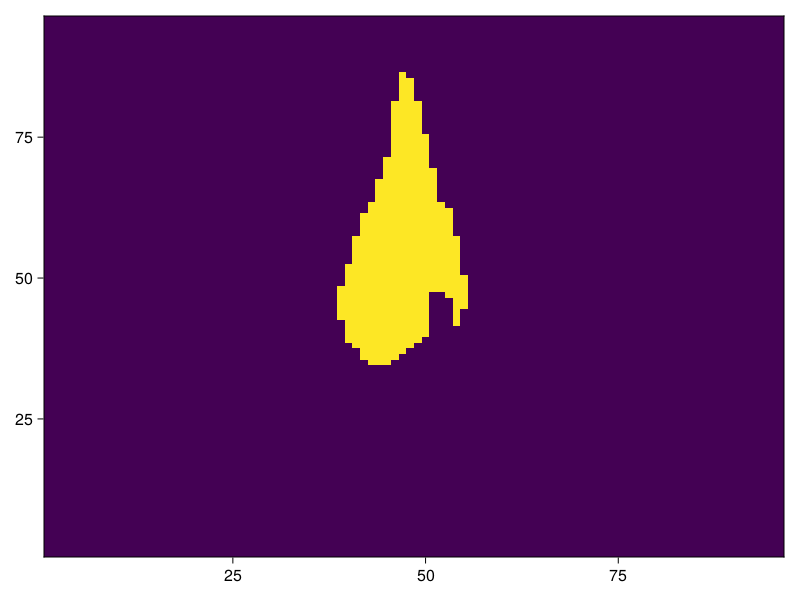

In [55]:
CairoMakie.heatmap(y1[43,:,:,1,1])

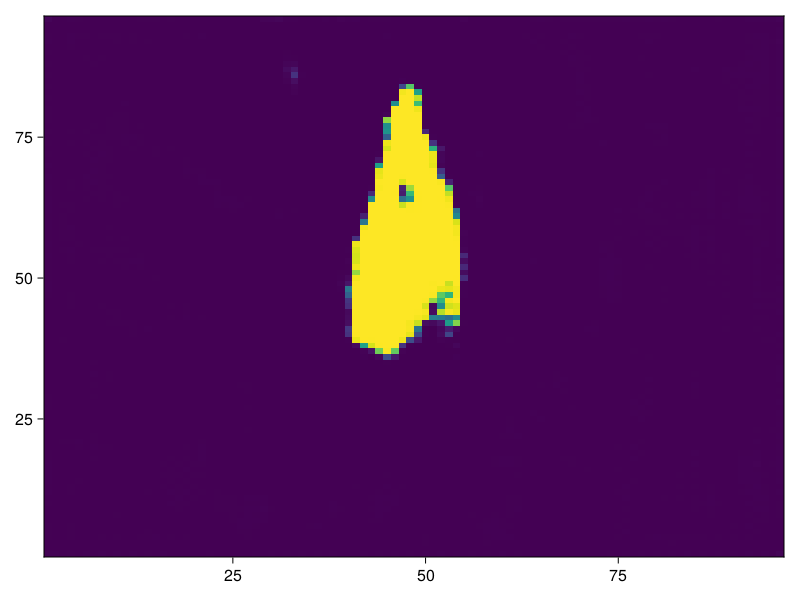

In [56]:
CairoMakie.heatmap(y_pred1[43,:,:,2,1])

## Load saved model from disk

In [29]:
task_from_disk, model_from_disk = loadtaskmodel("savedmodels/Dice_25.jld2");

## Inspect results

In [53]:
model_trained = model_from_disk |> gpu
(example1, ) = validdl
img_mask, mask_dtm = example1
x1, y1 = img_mask[1], img_mask[2] |> cpu
y_pred1 = model_trained(x1) |> cpu
chan_idx = 5;

UndefVarError: UndefVarError: model_from_disk not defined

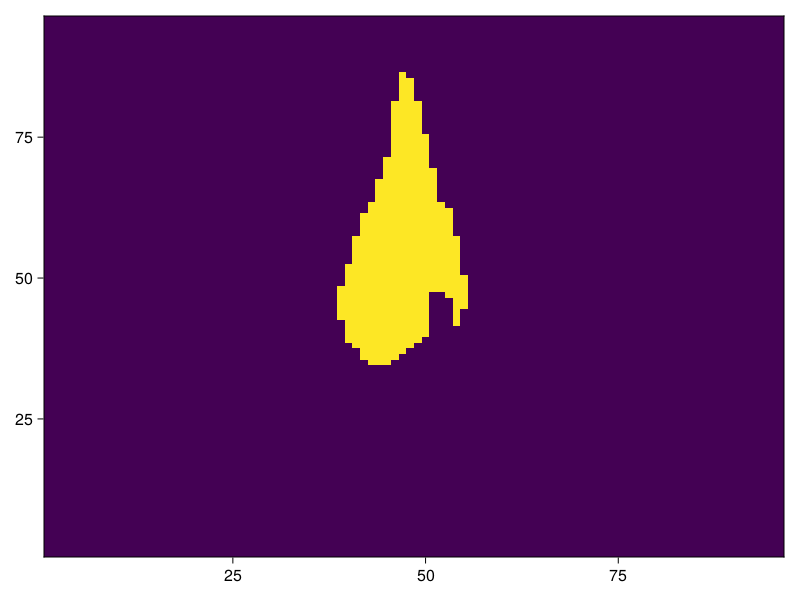

In [31]:
CairoMakie.heatmap(y1[43,:,:,1,1])

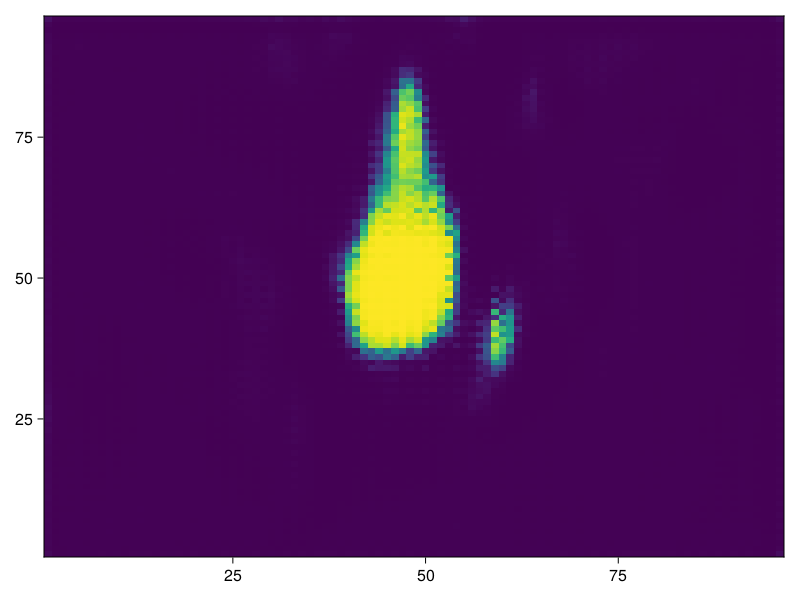

In [32]:
CairoMakie.heatmap(y_pred1[43,:,:,2,1])

# Train, Loss = Dice+HD

In [45]:
num_epochs_dice_hd = 30
epoch_times_dice_hd = []
step_times_dice_hd = []
epoch_train_losses_dice_hd = []
epoch_valid_losses_dice_hd = []
train_dice_metric_epoch_dice_hd = []
valid_dice_metric_epoch_dice_hd = []
train_hd_metric_epoch_dice_hd = []
valid_hd_metric_epoch_dice_hd = []
all_dice_metric_epoch_dice_hd = []
all_hd_metric_epoch_dice_hd = []
model2 = unet3D_new(1, 2) |> gpu
model_ps2 = Flux.params(model2)
optimizer = Adam() 
for epoch_idx = 1:num_epochs_dice_hd
    curr_time_epoch, curr_times_step, curr_train_losses, curr_valid_losses, curr_train_dice, curr_train_hd, curr_all_dice, 
    curr_valid_dice, curr_valid_hd, curr_all_hd = train_1_epoch_with_DICE_and_HD!(epoch_idx, model2, model_ps2, traindl, validdl, optimizer)
    # Record data
    push!(epoch_times_dice_hd, curr_time_epoch)
    for i in curr_times_step
        push!(step_times_dice_hd, i)
    end
    push!(epoch_train_losses_dice_hd, curr_train_losses)
    push!(epoch_valid_losses_dice_hd, curr_valid_losses)
    push!(train_dice_metric_epoch_dice_hd, curr_train_dice)
    push!(valid_dice_metric_epoch_dice_hd, curr_valid_dice)
    push!(train_hd_metric_epoch_dice_hd, curr_train_hd)
    push!(valid_hd_metric_epoch_dice_hd, curr_valid_hd)
    push!(all_dice_metric_epoch_dice_hd, curr_all_dice)
    push!(all_hd_metric_epoch_dice_hd, curr_all_hd)
    if epoch_idx % 25 == 0
        #save model
        savetaskmodel(string("savedmodels/Dice_HD_", epoch_idx, ".jld2"), task, model2, force = true) # saving as cpu model
    end
end

Epoch #1...


	Finished 4 steps --> Train loss = 1.3018395, Valid loss = 1.3072822, 
    Dice = 0.045114654092454694, HD = 76.69419795525604


Epoch #2...


	Finished 4 steps --> Train loss = 1.4896502, Valid loss = 1.4958231, 
    Dice = 0.031048084345885813, HD = 52.38320341483518


Epoch #3...


	Finished 4 steps --> Train loss = 1.4651212, Valid loss = 1.4763672, 
    Dice = 0.0629029643208999, HD = 53.4696175411794


Epoch #4...


	Finished 4 steps --> Train loss = 1.2781523, Valid loss = 1.2866638, 
    Dice = 0.15248134084064424, HD = 34.23448553724738


Epoch #5...


	Finished 4 steps --> Train loss = 1.0069071, Valid loss = 1.0141392, 
    Dice = 0.23595346865727876, HD = 26.795522013948524


Epoch #6...


	Finished 4 steps --> Train loss = 0.74439484, Valid loss = 0.74620926, 
    Dice = 0.42825539705545806, HD = 16.61324772583615


Epoch #7...


	Finished 4 steps --> Train loss = 0.49085495, Valid loss = 0.47221553, 
    Dice = 0.6301803998049732, HD = 11.445523142259598


Epoch #8...


	Finished 4 steps --> Train loss = 0.38196516, Valid loss = 0.3541187, 
    Dice = 0.6650140472649149, HD = 13.74772708486752


Epoch #9...


	Finished 4 steps --> Train loss = 0.303189, Valid loss = 0.27670026, 
    Dice = 0.7281672816728167, HD = 11.874342087037917


Epoch #10...


	Finished 4 steps --> Train loss = 0.32393602, Valid loss = 0.33731037, 
    Dice = 0.6132093023255814, HD = 14.594519519326424


Epoch #11...


	Finished 4 steps --> Train loss = 0.25165784, Valid loss = 0.25634992, 
    Dice = 0.7040269483999387, HD = 11.045361017187261


Epoch #12...


	Finished 4 steps --> Train loss = 0.24181038, Valid loss = 0.22502336, 
    Dice = 0.7660920449153883, HD = 9.433981132056603


Epoch #13...


	Finished 4 steps --> Train loss = 0.3893149, Valid loss = 0.42779294, 
    Dice = 0.4679261862917399, HD = 17.4928556845359


Epoch #14...


	Finished 4 steps --> Train loss = 0.24177936, Valid loss = 0.20307669, 
    Dice = 0.7707701637355974, HD = 8.12403840463596


Epoch #15...


	Finished 4 steps --> Train loss = 0.29539925, Valid loss = 0.32284218, 
    Dice = 0.6190887497300799, HD = 7.810249675906654


Epoch #16...


	Finished 4 steps --> Train loss = 0.37448555, Valid loss = 0.36642477, 
    Dice = 0.6250243997657623, HD = 11.045361017187261


Epoch #17...


	Finished 4 steps --> Train loss = 0.1947184, Valid loss = 0.20993413, 
    Dice = 0.7750652541071703, HD = 8.774964387392123


Epoch #18...


	Finished 4 steps --> Train loss = 0.2547406, Valid loss = 0.27309346, 
    Dice = 0.7028905964141968, HD = 9.486832980505138


Epoch #19...


	Finished 4 steps --> Train loss = 0.1846103, Valid loss = 0.20111735, 
    Dice = 0.7352812908853031, HD = 7.810249675906654


Epoch #20...


	Finished 4 steps --> Train loss = 0.16981974, Valid loss = 0.20715788, 
    Dice = 0.7688205771643664, HD = 7.810249675906654


Epoch #21...


	Finished 4 steps --> Train loss = 0.18376306, Valid loss = 0.21423699, 
    Dice = 0.7856315179606026, HD = 8.12403840463596


Epoch #22...


	Finished 4 steps --> Train loss = 0.16603296, Valid loss = 0.20146315, 
    Dice = 0.7385841250383083, HD = 8.774964387392123


Epoch #23...


	Finished 4 steps --> Train loss = 0.15952253, Valid loss = 0.18388279, 
    Dice = 0.7855816831683168, HD = 7.810249675906654


Epoch #24...


	Finished 4 steps --> Train loss = 0.15855889, Valid loss = 0.20524135, 
    Dice = 0.7801302931596091, HD = 8.12403840463596


Epoch #25...


	Finished 4 steps --> Train loss = 0.15906619, Valid loss = 0.18793735, 
    Dice = 0.7744047619047619, HD = 7.810249675906654

Epoch #26...


	Finished 4 steps --> Train loss = 0.16375819, Valid loss = 0.20628443, 
    Dice = 0.7806988352745424, HD = 8.12403840463596


Epoch #27...


	Finished 4 steps --> Train loss = 0.14940612, Valid loss = 0.19317213, 
    Dice = 0.7778144602178937, HD = 8.12403840463596


Epoch #28...


	Finished 4 steps --> Train loss = 0.16227041, Valid loss = 0.19252135, 
    Dice = 0.7583174556646637, HD = 7.810249675906654


Epoch #29...


	Finished 4 steps --> Train loss = 0.16267242, Valid loss = 0.19870637, 
    Dice = 0.7884517980752996, HD = 8.774964387392123


Epoch #30...


	Finished 4 steps --> Train loss = 0.14294979, Valid loss = 0.17871933, 
    Dice = 0.7702325581395348, HD = 8.12403840463596


In [46]:
for epoch_idx = 31:250
    curr_time_epoch, curr_times_step, curr_train_losses, curr_valid_losses, curr_train_dice, curr_train_hd, curr_all_dice, 
    curr_valid_dice, curr_valid_hd, curr_all_hd = train_1_epoch_with_DICE_and_HD!(epoch_idx, model2, model_ps2, traindl, validdl, optimizer)
    # Record data
    push!(epoch_times_dice_hd, curr_time_epoch)
    for i in curr_times_step
        push!(step_times_dice_hd, i)
    end
    push!(epoch_train_losses_dice_hd, curr_train_losses)
    push!(epoch_valid_losses_dice_hd, curr_valid_losses)
    push!(train_dice_metric_epoch_dice_hd, curr_train_dice)
    push!(valid_dice_metric_epoch_dice_hd, curr_valid_dice)
    push!(train_hd_metric_epoch_dice_hd, curr_train_hd)
    push!(valid_hd_metric_epoch_dice_hd, curr_valid_hd)
    push!(all_dice_metric_epoch_dice_hd, curr_all_dice)
    push!(all_hd_metric_epoch_dice_hd, curr_all_hd)
    if epoch_idx % 25 == 0
        #save model
        savetaskmodel(string("savedmodels/Dice_HD_", epoch_idx, ".jld2"), task, model2, force = true) # saving as cpu model
    end
end

Epoch #31...


	Finished 4 steps --> Train loss = 0.14436367, Valid loss = 0.18917556, 
    Dice = 0.781479217603912, HD = 8.12403840463596


Epoch #32...


	Finished 4 steps --> Train loss = 0.15468803, Valid loss = 0.19875385, 
    Dice = 0.765964851226727, HD = 10.246950765959598


Epoch #33...


	Finished 4 steps --> Train loss = 0.14368793, Valid loss = 0.17821617, 
    Dice = 0.7678653404743688, HD = 8.774964387392123


Epoch #34...


	Finished 4 steps --> Train loss = 0.13939437, Valid loss = 0.1958977, 
    Dice = 0.7820232284127251, HD = 8.774964387392123


Epoch #35...


	Finished 4 steps --> Train loss = 0.1421315, Valid loss = 0.19766381, 
    Dice = 0.7347856154910097, HD = 10.246950765959598


Epoch #36...


	Finished 4 steps --> Train loss = 0.13045517, Valid loss = 0.18554902, 
    Dice = 0.7687727423089646, HD = 8.774964387392123


Epoch #37...


	Finished 4 steps --> Train loss = 0.13243146, Valid loss = 0.19238937, 
    Dice = 0.7790274561693682, HD = 9.486832980505138


Epoch #38...


	Finished 4 steps --> Train loss = 0.1333924, Valid loss = 0.191365, 
    Dice = 0.7660808735710629, HD = 10.246950765959598


Epoch #39...


	Finished 4 steps --> Train loss = 0.1369037, Valid loss = 0.19605932, 
    Dice = 0.7308831214074203, HD = 10.246950765959598


Epoch #40...


	Finished 4 steps --> Train loss = 0.13228734, Valid loss = 0.19422193, 
    Dice = 0.7712440516655337, HD = 8.831760866327848


Epoch #41...


	Finished 4 steps --> Train loss = 0.12600175, Valid loss = 0.18906522, 
    Dice = 0.7806860673061291, HD = 8.660254037844387


Epoch #42...


	Finished 4 steps --> Train loss = 0.12897193, Valid loss = 0.17683874, 
    Dice = 0.7642405063291139, HD = 8.660254037844387


Epoch #43...


	Finished 4 steps --> Train loss = 0.12831397, Valid loss = 0.17997931, 
    Dice = 0.7867314458033171, HD = 8.366600265340756


Epoch #44...


	Finished 4 steps --> Train loss = 0.12770392, Valid loss = 0.18017805, 
    Dice = 0.7838330296504886, HD = 8.831760866327848


Epoch #45...


	Finished 4 steps --> Train loss = 0.12687317, Valid loss = 0.17581528, 
    Dice = 0.7685199936275291, HD = 8.660254037844387


Epoch #46...


	Finished 4 steps --> Train loss = 0.13019644, Valid loss = 0.19518487, 
    Dice = 0.7736249387954953, HD = 9.486832980505138


Epoch #47...


	Finished 4 steps --> Train loss = 0.122332916, Valid loss = 0.17207214, 
    Dice = 0.7933665008291874, HD = 7.3484692283495345


Epoch #48...


	Finished 4 steps --> Train loss = 0.1216304, Valid loss = 0.17938168, 
    Dice = 0.7657378740970072, HD = 8.660254037844387


Epoch #49...


	Finished 4 steps --> Train loss = 0.12691364, Valid loss = 0.20052928, 
    Dice = 0.7500876270592359, HD = 8.831760866327848


Epoch #50...


	Finished 4 steps --> Train loss = 0.11998856, Valid loss = 0.17387779, 
    Dice = 0.7897574123989218, HD = 8.660254037844387

Epoch #51...


	Finished 4 steps --> Train loss = 0.116480164, Valid loss = 0.18069698, 
    Dice = 0.8028933092224232, HD = 7.3484692283495345


Epoch #52...


	Finished 4 steps --> Train loss = 0.11342663, Valid loss = 0.17589708, 
    Dice = 0.7744411077744411, HD = 8.831760866327848


Epoch #53...


	Finished 4 steps --> Train loss = 0.13410263, Valid loss = 0.20049529, 
    Dice = 0.7462740168791524, HD = 9.486832980505138


Epoch #54...


	Finished 4 steps --> Train loss = 0.12826586, Valid loss = 0.19137621, 
    Dice = 0.760652288269332, HD = 10.246950765959598


Epoch #55...


	Finished 4 steps --> Train loss = 0.11725363, Valid loss = 0.17066069, 
    Dice = 0.7913016270337923, HD = 7.3484692283495345


Epoch #56...


	Finished 4 steps --> Train loss = 0.11429024, Valid loss = 0.17481714, 
    Dice = 0.7904096538583677, HD = 8.831760866327848


Epoch #57...


	Finished 4 steps --> Train loss = 0.13931231, Valid loss = 0.19661762, 
    Dice = 0.7656082768462362, HD = 7.3484692283495345


Epoch #58...


	Finished 4 steps --> Train loss = 0.11407737, Valid loss = 0.17784894, 
    Dice = 0.7622073578595318, HD = 10.246950765959598


Epoch #59...


	Finished 4 steps --> Train loss = 0.11330843, Valid loss = 0.17218454, 
    Dice = 0.7710881153966761, HD = 7.3484692283495345


Epoch #60...


	Finished 4 steps --> Train loss = 0.11402018, Valid loss = 0.17925659, 
    Dice = 0.7947438456420493, HD = 8.660254037844387


Epoch #61...


	Finished 4 steps --> Train loss = 0.064839676, Valid loss = 0.12106582, 
    Dice = 0.8252131546894031, HD = 9.16515138991168


Epoch #62...


	Finished 4 steps --> Train loss = 0.097008735, Valid loss = 0.17255352, 
    Dice = 0.7595756158964215, HD = 10.246950765959598


Epoch #63...


	Finished 4 steps --> Train loss = 0.058843296, Valid loss = 0.123968914, 
    Dice = 0.8371005455962588, HD = 9.0


Epoch #64...


	Finished 4 steps --> Train loss = 0.06530966, Valid loss = 0.11488129, 
    Dice = 0.8211009174311926, HD = 8.602325267042627


Epoch #65...


	Finished 4 steps --> Train loss = 0.0607834, Valid loss = 0.12146892, 
    Dice = 0.8542069992553983, HD = 8.366600265340756


Epoch #66...


	Finished 4 steps --> Train loss = 0.04523447, Valid loss = 0.12124288, 
    Dice = 0.8353838965893163, HD = 7.3484692283495345


Epoch #67...


	Finished 4 steps --> Train loss = 0.052806187, Valid loss = 0.13566595, 
    Dice = 0.7953312510274536, HD = 9.486832980505138


Epoch #68...


	Finished 4 steps --> Train loss = 0.09747834, Valid loss = 0.16362047, 
    Dice = 0.790245626435766, HD = 10.246950765959598


Epoch #69...


	Finished 4 steps --> Train loss = 0.04700693, Valid loss = 0.10361527, 
    Dice = 0.8466725300498388, HD = 9.16515138991168


Epoch #70...


	Finished 4 steps --> Train loss = 0.044033047, Valid loss = 0.11150479, 
    Dice = 0.8464991023339318, HD = 9.16515138991168


Epoch #71...


	Finished 4 steps --> Train loss = 0.06716011, Valid loss = 0.14126794, 
    Dice = 0.814276048714479, HD = 10.246950765959598


Epoch #72...


	Finished 4 steps --> Train loss = 0.0540983, Valid loss = 0.121739276, 
    Dice = 0.803088803088803, HD = 7.874007874011811


Epoch #73...


	Finished 4 steps --> Train loss = 0.04709403, Valid loss = 0.12311674, 
    Dice = 0.8511583624246271, HD = 9.16515138991168


Epoch #74...


	Finished 4 steps --> Train loss = 0.0464332, Valid loss = 0.10681312, 
    Dice = 0.8447880870561283, HD = 8.602325267042627


Epoch #75...


	Finished 4 steps --> Train loss = 0.04867626, Valid loss = 0.11835026, 
    Dice = 0.8156299840510367, HD = 9.16515138991168


Epoch #76...


	Finished 4 steps --> Train loss = 0.06000275, Valid loss = 0.13895948, 
    Dice = 0.8218107694921012, HD = 9.9498743710662


Epoch #77...


	Finished 4 steps --> Train loss = 0.043937936, Valid loss = 0.1043137, 
    Dice = 0.8415395787944807, HD = 6.4031242374328485


Epoch #78...


	Finished 4 steps --> Train loss = 0.03622015, Valid loss = 0.11672107, 
    Dice = 0.8359887535145267, HD = 9.16515138991168


Epoch #79...


	Finished 4 steps --> Train loss = 0.05201967, Valid loss = 0.1290637, 
    Dice = 0.8255389718076285, HD = 9.486832980505138


Epoch #80...


	Finished 4 steps --> Train loss = 0.046794925, Valid loss = 0.12304759, 
    Dice = 0.8124583610926049, HD = 9.486832980505138


Epoch #81...


	Finished 4 steps --> Train loss = 0.036684215, Valid loss = 0.12269787, 
    Dice = 0.8413661027768912, HD = 9.486832980505138


Epoch #82...


	Finished 4 steps --> Train loss = 0.041847292, Valid loss = 0.10913616, 
    Dice = 0.8462311557788945, HD = 6.557438524302


Epoch #83...


	Finished 4 steps --> Train loss = 0.048096128, Valid loss = 0.120945014, 
    Dice = 0.8226229508196722, HD = 6.48074069840786


Epoch #84...


	Finished 4 steps --> Train loss = 0.051614475, Valid loss = 0.13245356, 
    Dice = 0.8214881548214882, HD = 9.539392014169456


Epoch #85...


	Finished 4 steps --> Train loss = 0.047672365, Valid loss = 0.117499955, 
    Dice = 0.8315422596572757, HD = 6.557438524302


Epoch #86...


	Finished 4 steps --> Train loss = 0.036780566, Valid loss = 0.10505423, 
    Dice = 0.8530732311503328, HD = 7.3484692283495345


Epoch #87...


	Finished 4 steps --> Train loss = 0.0344948, Valid loss = 0.10552263, 
    Dice = 0.8384318384318384, HD = 9.38083151964686


Epoch #88...


	Finished 4 steps --> Train loss = 0.03299073, Valid loss = 0.12153261, 
    Dice = 0.8340315823396713, HD = 9.38083151964686


Epoch #89...


	Finished 4 steps --> Train loss = 0.05123793, Valid loss = 0.13175772, 
    Dice = 0.8122878479293958, HD = 9.539392014169456


Epoch #90...


	Finished 4 steps --> Train loss = 0.030707328, Valid loss = 0.10949683, 
    Dice = 0.8297443841982959, HD = 9.38083151964686


Epoch #91...


	Finished 4 steps --> Train loss = 0.0329526, Valid loss = 0.11782746, 
    Dice = 0.8410617204988807, HD = 6.4031242374328485


Epoch #92...


	Finished 4 steps --> Train loss = 0.029354973, Valid loss = 0.108397566, 
    Dice = 0.8492298578199052, HD = 9.38083151964686


Epoch #93...


	Finished 4 steps --> Train loss = 0.043400444, Valid loss = 0.12580664, 
    Dice = 0.8124383020730503, HD = 9.38083151964686


Epoch #94...


	Finished 4 steps --> Train loss = 0.047813162, Valid loss = 0.13595335, 
    Dice = 0.8108016877637131, HD = 10.770329614269007


Epoch #95...


	Finished 4 steps --> Train loss = 0.03131395, Valid loss = 0.10722141, 
    Dice = 0.853049771082558, HD = 6.4031242374328485


Epoch #96...


	Finished 4 steps --> Train loss = 0.02793201, Valid loss = 0.10813015, 
    Dice = 0.8452103710603943, HD = 5.477225575051661


Epoch #97...


	Finished 4 steps --> Train loss = 0.050129853, Valid loss = 0.13599445, 
    Dice = 0.8033670033670034, HD = 10.770329614269007


Epoch #98...


	Finished 4 steps --> Train loss = 0.029801963, Valid loss = 0.10999838, 
    Dice = 0.8372539606337014, HD = 5.744562646538029


Epoch #99...


	Finished 4 steps --> Train loss = 0.025746645, Valid loss = 0.104062416, 
    Dice = 0.8617836346920013, HD = 6.4031242374328485


Epoch #100...


	Finished 4 steps --> Train loss = 0.02812377, Valid loss = 0.11613284, 
    Dice = 0.8366890380313199, HD = 9.38083151964686

Epoch #101...


	Finished 4 steps --> Train loss = 0.03236823, Valid loss = 0.11728542, 
    Dice = 0.8209806157354618, HD = 9.539392014169456


Epoch #102...


	Finished 4 steps --> Train loss = 0.023616783, Valid loss = 0.109547615, 
    Dice = 0.8516776418940106, HD = 9.38083151964686


Epoch #103...


	Finished 4 steps --> Train loss = 0.024421593, Valid loss = 0.11351855, 
    Dice = 0.8470659775007601, HD = 6.4031242374328485


Epoch #104...


	Finished 4 steps --> Train loss = 0.032312017, Valid loss = 0.1098301, 
    Dice = 0.8272267845862287, HD = 9.38083151964686


Epoch #105...


	Finished 4 steps --> Train loss = 0.022878528, Valid loss = 0.11007041, 
    Dice = 0.8367092552196946, HD = 9.486832980505138


Epoch #106...


	Finished 4 steps --> Train loss = 0.027667938, Valid loss = 0.115762755, 
    Dice = 0.8568336425479283, HD = 5.744562646538029


Epoch #107...


	Finished 4 steps --> Train loss = 0.028784057, Valid loss = 0.10246827, 
    Dice = 0.8294916806594413, HD = 9.38083151964686


Epoch #108...


	Finished 4 steps --> Train loss = 0.025973666, Valid loss = 0.116934955, 
    Dice = 0.8352885969028625, HD = 9.38083151964686


Epoch #109...


	Finished 4 steps --> Train loss = 0.026121857, Valid loss = 0.11028107, 
    Dice = 0.841565105837075, HD = 9.486832980505138


Epoch #110...


	Finished 4 steps --> Train loss = 0.020719986, Valid loss = 0.10760462, 
    Dice = 0.8404104183109709, HD = 9.486832980505138


Epoch #111...


	Finished 4 steps --> Train loss = 0.023118572, Valid loss = 0.11189787, 
    Dice = 0.8336495888678052, HD = 9.486832980505138


Epoch #112...


	Finished 4 steps --> Train loss = 0.023744622, Valid loss = 0.107684575, 
    Dice = 0.8450390189520625, HD = 9.486832980505138


Epoch #113...


	Finished 4 steps --> Train loss = 0.022484124, Valid loss = 0.10980336, 
    Dice = 0.8468631897203326, HD = 9.486832980505138


Epoch #114...


	Finished 4 steps --> Train loss = 0.022981094, Valid loss = 0.10721418, 
    Dice = 0.8383100381194409, HD = 9.38083151964686


Epoch #115...


	Finished 4 steps --> Train loss = 0.026914824, Valid loss = 0.11861498, 
    Dice = 0.8309241513724216, HD = 10.770329614269007


Epoch #116...


	Finished 4 steps --> Train loss = 0.02074074, Valid loss = 0.106556736, 
    Dice = 0.8329145728643216, HD = 9.16515138991168


Epoch #117...


	Finished 4 steps --> Train loss = 0.021061104, Valid loss = 0.11042316, 
    Dice = 0.8530135301353013, HD = 9.486832980505138


Epoch #118...


	Finished 4 steps --> Train loss = 0.019047143, Valid loss = 0.10797875, 
    Dice = 0.8454685099846391, HD = 9.38083151964686


Epoch #119...


	Finished 4 steps --> Train loss = 0.03273815, Valid loss = 0.118949056, 
    Dice = 0.8069610054785691, HD = 9.38083151964686


Epoch #120...


	Finished 4 steps --> Train loss = 0.02679153, Valid loss = 0.11510438, 
    Dice = 0.8495857233906947, HD = 9.486832980505138


Epoch #121...


	Finished 4 steps --> Train loss = 0.023204593, Valid loss = 0.10462864, 
    Dice = 0.839882697947214, HD = 9.16515138991168


Epoch #122...


	Finished 4 steps --> Train loss = 0.024559906, Valid loss = 0.112275064, 
    Dice = 0.8473111395646606, HD = 5.744562646538029


Epoch #123...


	Finished 4 steps --> Train loss = 0.02729382, Valid loss = 0.11769699, 
    Dice = 0.8262145418976198, HD = 9.38083151964686


Epoch #124...


	Finished 4 steps --> Train loss = 0.020637244, Valid loss = 0.10360487, 
    Dice = 0.8454680534918276, HD = 9.38083151964686


Epoch #125...


	Finished 4 steps --> Train loss = 0.024609625, Valid loss = 0.1104628, 
    Dice = 0.8570978414999212, HD = 5.744562646538029

Epoch #126...


	Finished 4 steps --> Train loss = 0.017691605, Valid loss = 0.10304777, 
    Dice = 0.8390875462392109, HD = 9.38083151964686


Epoch #127...


	Finished 4 steps --> Train loss = 0.018431824, Valid loss = 0.114985764, 
    Dice = 0.8334135000801668, HD = 10.04987562112089


Epoch #128...


	Finished 4 steps --> Train loss = 0.015932063, Valid loss = 0.10081775, 
    Dice = 0.8594389689158454, HD = 6.4031242374328485


Epoch #129...


	Finished 4 steps --> Train loss = 0.015599316, Valid loss = 0.10947848, 
    Dice = 0.8400800369401262, HD = 9.38083151964686


Epoch #130...


	Finished 4 steps --> Train loss = 0.029524045, Valid loss = 0.119312115, 
    Dice = 0.8269073010664479, HD = 9.38083151964686


Epoch #131...


	Finished 4 steps --> Train loss = 0.015409806, Valid loss = 0.10454008, 
    Dice = 0.8398687705046086, HD = 9.38083151964686


Epoch #132...


	Finished 4 steps --> Train loss = 0.018617168, Valid loss = 0.111052155, 
    Dice = 0.8514200298953662, HD = 6.48074069840786


Epoch #133...


	Finished 4 steps --> Train loss = 0.017112816, Valid loss = 0.104178734, 
    Dice = 0.8480662983425414, HD = 9.38083151964686


Epoch #134...


	Finished 4 steps --> Train loss = 0.03213993, Valid loss = 0.12362054, 
    Dice = 0.8152173913043478, HD = 9.38083151964686


Epoch #135...


	Finished 4 steps --> Train loss = 0.016877273, Valid loss = 0.10620511, 
    Dice = 0.8516383495145631, HD = 9.486832980505138


Epoch #136...


	Finished 4 steps --> Train loss = 0.018026933, Valid loss = 0.103874445, 
    Dice = 0.8420559287611311, HD = 9.38083151964686


Epoch #137...


	Finished 4 steps --> Train loss = 0.01988218, Valid loss = 0.113756076, 
    Dice = 0.8461538461538461, HD = 9.486832980505138


Epoch #138...


	Finished 4 steps --> Train loss = 0.013592339, Valid loss = 0.10608959, 
    Dice = 0.8428462127008416, HD = 9.38083151964686


Epoch #139...


	Finished 4 steps --> Train loss = 0.01367097, Valid loss = 0.10473997, 
    Dice = 0.8471833177715531, HD = 9.38083151964686


Epoch #140...


	Finished 4 steps --> Train loss = 0.021896765, Valid loss = 0.113738485, 
    Dice = 0.8439807383627609, HD = 9.38083151964686


Epoch #141...


	Finished 4 steps --> Train loss = 0.013076791, Valid loss = 0.105762236, 
    Dice = 0.8486892534110072, HD = 6.4031242374328485


Epoch #142...


	Finished 4 steps --> Train loss = 0.011762301, Valid loss = 0.1074735, 
    Dice = 0.8500309214594929, HD = 9.38083151964686


Epoch #143...


	Finished 4 steps --> Train loss = 0.02016908, Valid loss = 0.112387255, 
    Dice = 0.8367248838327191, HD = 9.38083151964686


Epoch #144...


	Finished 4 steps --> Train loss = 0.011801058, Valid loss = 0.10606162, 
    Dice = 0.8496309963099631, HD = 6.4031242374328485


Epoch #145...


	Finished 4 steps --> Train loss = 0.011863688, Valid loss = 0.11168803, 
    Dice = 0.8434212532398232, HD = 9.16515138991168


Epoch #146...


	Finished 4 steps --> Train loss = 0.019805498, Valid loss = 0.10445866, 
    Dice = 0.8455361360415683, HD = 9.38083151964686


Epoch #147...


	Finished 4 steps --> Train loss = 0.01121566, Valid loss = 0.1060592, 
    Dice = 0.848699399722949, HD = 6.48074069840786


Epoch #148...


	Finished 4 steps --> Train loss = 0.013929114, Valid loss = 0.1095691, 
    Dice = 0.848621103117506, HD = 9.16515138991168


Epoch #149...


	Finished 4 steps --> Train loss = 0.022291284, Valid loss = 0.10536275, 
    Dice = 0.8427393785668992, HD = 7.874007874011811


Epoch #150...


	Finished 4 steps --> Train loss = 0.0114737265, Valid loss = 0.10791667, 
    Dice = 0.853514739229025, HD = 9.38083151964686


Epoch #151...


	Finished 4 steps --> Train loss = 0.011010834, Valid loss = 0.10430486, 
    Dice = 0.8438948995363215, HD = 6.4031242374328485


Epoch #152...


	Finished 4 steps --> Train loss = 0.017604107, Valid loss = 0.105973214, 
    Dice = 0.8477848101265822, HD = 6.4031242374328485


Epoch #153...


	Finished 4 steps --> Train loss = 0.012406791, Valid loss = 0.11141151, 
    Dice = 0.847953216374269, HD = 9.38083151964686


Epoch #154...


	Finished 4 steps --> Train loss = 0.014188644, Valid loss = 0.098782964, 
    Dice = 0.8446703543130513, HD = 6.48074069840786


Epoch #155...


	Finished 4 steps --> Train loss = 0.014755309, Valid loss = 0.11218754, 
    Dice = 0.8451194431260877, HD = 10.04987562112089


Epoch #156...


	Finished 4 steps --> Train loss = 0.011883745, Valid loss = 0.10373037, 
    Dice = 0.8520543665052336, HD = 9.16515138991168


Epoch #157...


	Finished 4 steps --> Train loss = 0.010527261, Valid loss = 0.10216205, 
    Dice = 0.8459784096092443, HD = 9.38083151964686


Epoch #158...


	Finished 4 steps --> Train loss = 0.010805612, Valid loss = 0.10841253, 
    Dice = 0.8502864220467564, HD = 9.486832980505138


Epoch #159...


	Finished 4 steps --> Train loss = 0.01696389, Valid loss = 0.1021798, 
    Dice = 0.851682198704786, HD = 7.874007874011811


Epoch #160...


	Finished 4 steps --> Train loss = 0.01293497, Valid loss = 0.106501214, 
    Dice = 0.8454315099120584, HD = 9.899494936611665


Epoch #161...


	Finished 4 steps --> Train loss = 0.009564167, Valid loss = 0.10474747, 
    Dice = 0.841717791411043, HD = 9.38083151964686


Epoch #162...


	Finished 4 steps --> Train loss = 0.019625382, Valid loss = 0.10775473, 
    Dice = 0.8505236432878451, HD = 9.486832980505138


Epoch #163...


	Finished 4 steps --> Train loss = 0.009637475, Valid loss = 0.1040517, 
    Dice = 0.8474627772713461, HD = 9.899494936611665


Epoch #164...


	Finished 4 steps --> Train loss = 0.009044818, Valid loss = 0.10265236, 
    Dice = 0.8484756097560976, HD = 9.899494936611665


Epoch #165...


	Finished 4 steps --> Train loss = 0.016501455, Valid loss = 0.11212284, 
    Dice = 0.8402234636871508, HD = 9.38083151964686


Epoch #166...


	Finished 4 steps --> Train loss = 0.010023834, Valid loss = 0.0999276, 
    Dice = 0.8437876960193004, HD = 9.899494936611665


Epoch #167...


	Finished 4 steps --> Train loss = 0.012119364, Valid loss = 0.10776687, 
    Dice = 0.8516365861119608, HD = 9.899494936611665


Epoch #168...


	Finished 4 steps --> Train loss = 0.010381589, Valid loss = 0.1023693, 
    Dice = 0.8464339908952959, HD = 9.899494936611665


Epoch #169...


	Finished 4 steps --> Train loss = 0.012539348, Valid loss = 0.10650143, 
    Dice = 0.8424166926191218, HD = 9.899494936611665


Epoch #170...


	Finished 4 steps --> Train loss = 0.012547832, Valid loss = 0.10105572, 
    Dice = 0.8623990427759497, HD = 9.899494936611665


Epoch #171...


	Finished 4 steps --> Train loss = 0.014601683, Valid loss = 0.10702945, 
    Dice = 0.8259707593145732, HD = 9.539392014169456


Epoch #172...


	Finished 4 steps --> Train loss = 0.0121204, Valid loss = 0.105213635, 
    Dice = 0.8553204729309272, HD = 9.38083151964686


Epoch #173...


	Finished 4 steps --> Train loss = 0.008426759, Valid loss = 0.10246183, 
    Dice = 0.8515933232169954, HD = 9.38083151964686


Epoch #174...


	Finished 4 steps --> Train loss = 0.008977659, Valid loss = 0.1061847, 
    Dice = 0.841083450759355, HD = 9.38083151964686


Epoch #175...


	Finished 4 steps --> Train loss = 0.012647113, Valid loss = 0.10300435, 
    Dice = 0.855, HD = 9.433981132056603

Epoch #176...


	Finished 4 steps --> Train loss = 0.007840011, Valid loss = 0.10098347, 
    Dice = 0.8512620192307693, HD = 9.899494936611665


Epoch #177...


	Finished 4 steps --> Train loss = 0.009831267, Valid loss = 0.10674343, 
    Dice = 0.8517360025023459, HD = 9.899494936611665


Epoch #178...


	Finished 4 steps --> Train loss = 0.008466295, Valid loss = 0.10075277, 
    Dice = 0.8485128679303436, HD = 9.899494936611665


Epoch #179...


	Finished 4 steps --> Train loss = 0.0069849053, Valid loss = 0.10361705, 
    Dice = 0.8518575141415685, HD = 9.899494936611665


Epoch #180...


	Finished 4 steps --> Train loss = 0.006613517, Valid loss = 0.10053093, 
    Dice = 0.852762598664238, HD = 9.899494936611665


Epoch #181...


	Finished 4 steps --> Train loss = 0.0102519, Valid loss = 0.1042181, 
    Dice = 0.8447653429602888, HD = 10.04987562112089


Epoch #182...


	Finished 4 steps --> Train loss = 0.0065410146, Valid loss = 0.102678604, 
    Dice = 0.8548756294826797, HD = 9.899494936611665


Epoch #183...


	Finished 4 steps --> Train loss = 0.006753559, Valid loss = 0.09997405, 
    Dice = 0.8501878287002254, HD = 9.899494936611665


Epoch #184...


	Finished 4 steps --> Train loss = 0.012652025, Valid loss = 0.10734098, 
    Dice = 0.8424232787406583, HD = 10.04987562112089


Epoch #185...


	Finished 4 steps --> Train loss = 0.0066169305, Valid loss = 0.099760145, 
    Dice = 0.8527344943476932, HD = 9.899494936611665


Epoch #186...


	Finished 4 steps --> Train loss = 0.008027682, Valid loss = 0.10159461, 
    Dice = 0.8491186136838961, HD = 9.899494936611665


Epoch #187...


	Finished 4 steps --> Train loss = 0.011446907, Valid loss = 0.10684098, 
    Dice = 0.8465675419171148, HD = 10.770329614269007


Epoch #188...


	Finished 4 steps --> Train loss = 0.008746849, Valid loss = 0.09851137, 
    Dice = 0.8473012455789636, HD = 9.899494936611665


Epoch #189...


	Finished 4 steps --> Train loss = 0.00854531, Valid loss = 0.10337772, 
    Dice = 0.8497144574691915, HD = 9.899494936611665


Epoch #190...


	Finished 4 steps --> Train loss = 0.009732091, Valid loss = 0.106272236, 
    Dice = 0.8471807758756086, HD = 9.899494936611665


Epoch #191...


	Finished 4 steps --> Train loss = 0.0076594483, Valid loss = 0.09774664, 
    Dice = 0.8483094730429486, HD = 9.899494936611665


Epoch #192...


	Finished 4 steps --> Train loss = 0.008388236, Valid loss = 0.10392424, 
    Dice = 0.8497222639243357, HD = 9.486832980505138


Epoch #193...


	Finished 4 steps --> Train loss = 0.01778834, Valid loss = 0.11000759, 
    Dice = 0.8306647258612324, HD = 10.770329614269007


Epoch #194...


	Finished 4 steps --> Train loss = 0.0064341696, Valid loss = 0.098357104, 
    Dice = 0.8554234993230029, HD = 9.899494936611665


Epoch #195...


	Finished 4 steps --> Train loss = 0.010199258, Valid loss = 0.10064271, 
    Dice = 0.8483866214822454, HD = 9.899494936611665


Epoch #196...


	Finished 4 steps --> Train loss = 0.022703158, Valid loss = 0.11539737, 
    Dice = 0.8222185810257251, HD = 10.770329614269007


Epoch #197...


	Finished 4 steps --> Train loss = 0.007389676, Valid loss = 0.098674476, 
    Dice = 0.8548411612707099, HD = 9.899494936611665


Epoch #198...


	Finished 4 steps --> Train loss = 0.008068636, Valid loss = 0.099412195, 
    Dice = 0.843329808128116, HD = 9.899494936611665


Epoch #199...


	Finished 4 steps --> Train loss = 0.012292672, Valid loss = 0.10376119, 
    Dice = 0.8530923819909644, HD = 10.04987562112089


Epoch #200...


	Finished 4 steps --> Train loss = 0.0068603596, Valid loss = 0.09450102, 
    Dice = 0.8513268998793727, HD = 9.899494936611665

Epoch #201...


	Finished 4 steps --> Train loss = 0.007869076, Valid loss = 0.10659974, 
    Dice = 0.840983863387122, HD = 10.770329614269007


Epoch #202...


	Finished 4 steps --> Train loss = 0.0069329217, Valid loss = 0.09623023, 
    Dice = 0.8547768747124674, HD = 9.899494936611665


Epoch #203...


	Finished 4 steps --> Train loss = 0.005415355, Valid loss = 0.099143915, 
    Dice = 0.8470873786407767, HD = 9.899494936611665


Epoch #204...


	Finished 4 steps --> Train loss = 0.0067445464, Valid loss = 0.10136314, 
    Dice = 0.8474945533769063, HD = 10.04987562112089


Epoch #205...


	Finished 4 steps --> Train loss = 0.0050203586, Valid loss = 0.09924132, 
    Dice = 0.8498618360454406, HD = 10.04987562112089


Epoch #206...


	Finished 4 steps --> Train loss = 0.004970651, Valid loss = 0.09952826, 
    Dice = 0.8526873580620742, HD = 10.04987562112089


Epoch #207...


	Finished 4 steps --> Train loss = 0.006590082, Valid loss = 0.09681673, 
    Dice = 0.8482225656877898, HD = 9.899494936611665


Epoch #208...


	Finished 4 steps --> Train loss = 0.004696835, Valid loss = 0.10099209, 
    Dice = 0.8507645259938837, HD = 10.04987562112089


Epoch #209...


	Finished 4 steps --> Train loss = 0.00432879, Valid loss = 0.09772185, 
    Dice = 0.8500153045607591, HD = 10.04987562112089


Epoch #210...


	Finished 4 steps --> Train loss = 0.0048232563, Valid loss = 0.099311054, 
    Dice = 0.8511426806670784, HD = 9.899494936611665


Epoch #211...


	Finished 4 steps --> Train loss = 0.004201942, Valid loss = 0.09810673, 
    Dice = 0.849750340444848, HD = 10.04987562112089


Epoch #212...


	Finished 4 steps --> Train loss = 0.005113437, Valid loss = 0.10025176, 
    Dice = 0.8492938072326556, HD = 10.04987562112089


Epoch #213...


	Finished 4 steps --> Train loss = 0.0038390975, Valid loss = 0.09755377, 
    Dice = 0.8518292682926829, HD = 10.04987562112089


Epoch #214...


	Finished 4 steps --> Train loss = 0.0038476754, Valid loss = 0.10020831, 
    Dice = 0.8511029411764706, HD = 10.04987562112089


Epoch #215...


	Finished 4 steps --> Train loss = 0.0043491633, Valid loss = 0.09838219, 
    Dice = 0.8497920197196118, HD = 10.04987562112089


Epoch #216...


	Finished 4 steps --> Train loss = 0.003581932, Valid loss = 0.09902853, 
    Dice = 0.8507076548470552, HD = 10.04987562112089


Epoch #217...


	Finished 4 steps --> Train loss = 0.0037316978, Valid loss = 0.09957802, 
    Dice = 0.8496390723391184, HD = 10.04987562112089


Epoch #218...


	Finished 4 steps --> Train loss = 0.0041452223, Valid loss = 0.0982453, 
    Dice = 0.8495220474868949, HD = 10.04987562112089


Epoch #219...


	Finished 4 steps --> Train loss = 0.00356356, Valid loss = 0.09967544, 
    Dice = 0.8486782133090246, HD = 10.04987562112089


Epoch #220...


	Finished 4 steps --> Train loss = 0.0037821932, Valid loss = 0.09908963, 
    Dice = 0.8492392807745505, HD = 10.04987562112089


Epoch #221...


	Finished 4 steps --> Train loss = 0.0039126864, Valid loss = 0.0983453, 
    Dice = 0.8498382873864161, HD = 10.04987562112089


Epoch #222...


	Finished 4 steps --> Train loss = 0.0035438824, Valid loss = 0.09962166, 
    Dice = 0.8478983973389779, HD = 10.04987562112089


Epoch #223...


	Finished 4 steps --> Train loss = 0.0041850028, Valid loss = 0.099351734, 
    Dice = 0.8456189151599444, HD = 10.04987562112089


Epoch #224...


	Finished 4 steps --> Train loss = 0.0036149512, Valid loss = 0.09808425, 
    Dice = 0.8494623655913979, HD = 10.04987562112089


Epoch #225...


	Finished 4 steps --> Train loss = 0.003576516, Valid loss = 0.09953368, 
    Dice = 0.8476262245666918, HD = 10.04987562112089

Epoch #226...


	Finished 4 steps --> Train loss = 0.0046952204, Valid loss = 0.09952234, 
    Dice = 0.8446239900559354, HD = 10.04987562112089


Epoch #227...


	Finished 4 steps --> Train loss = 0.003196157, Valid loss = 0.098197974, 
    Dice = 0.8484477748891268, HD = 10.04987562112089


Epoch #228...


	Finished 4 steps --> Train loss = 0.0031886008, Valid loss = 0.099331535, 
    Dice = 0.8480362537764351, HD = 10.04987562112089


Epoch #229...


	Finished 4 steps --> Train loss = 0.004944611, Valid loss = 0.09917267, 
    Dice = 0.8450397134402741, HD = 10.04987562112089


Epoch #230...


	Finished 4 steps --> Train loss = 0.003133283, Valid loss = 0.098782964, 
    Dice = 0.8481913122445891, HD = 10.04987562112089


Epoch #231...


	Finished 4 steps --> Train loss = 0.0029924395, Valid loss = 0.098710895, 
    Dice = 0.8464717587632022, HD = 10.04987562112089


Epoch #232...


	Finished 4 steps --> Train loss = 0.0038856245, Valid loss = 0.09875333, 
    Dice = 0.8455939290692271, HD = 10.04987562112089


Epoch #233...


	Finished 4 steps --> Train loss = 0.0032278406, Valid loss = 0.098589554, 
    Dice = 0.8489056603773585, HD = 10.04987562112089


Epoch #234...


	Finished 4 steps --> Train loss = 0.0039027552, Valid loss = 0.09954923, 
    Dice = 0.8449961210240496, HD = 10.04987562112089


Epoch #235...


	Finished 4 steps --> Train loss = 0.00282056, Valid loss = 0.09735344, 
    Dice = 0.8483650190114068, HD = 10.04987562112089


Epoch #236...


	Finished 4 steps --> Train loss = 0.0027674185, Valid loss = 0.0988842, 
    Dice = 0.8465753424657534, HD = 10.04987562112089


Epoch #237...


	Finished 4 steps --> Train loss = 0.003770738, Valid loss = 0.09856098, 
    Dice = 0.8443271767810027, HD = 10.04987562112089


Epoch #238...


	Finished 4 steps --> Train loss = 0.0031119003, Valid loss = 0.09821894, 
    Dice = 0.847228481297882, HD = 10.04987562112089


Epoch #239...


	Finished 4 steps --> Train loss = 0.0035107443, Valid loss = 0.098786965, 
    Dice = 0.8446571957998764, HD = 10.04987562112089


Epoch #240...


	Finished 4 steps --> Train loss = 0.0029347492, Valid loss = 0.09718874, 
    Dice = 0.844499078057775, HD = 10.04987562112089


Epoch #241...


	Finished 4 steps --> Train loss = 0.0030573811, Valid loss = 0.099120475, 
    Dice = 0.8460267387712183, HD = 10.04987562112089


Epoch #242...


	Finished 4 steps --> Train loss = 0.0047498425, Valid loss = 0.098209724, 
    Dice = 0.8433847592332866, HD = 10.04987562112089


Epoch #243...


	Finished 4 steps --> Train loss = 0.0030154, Valid loss = 0.0979896, 
    Dice = 0.8451467268623025, HD = 10.04987562112089


Epoch #244...


	Finished 4 steps --> Train loss = 0.002897288, Valid loss = 0.09848155, 
    Dice = 0.8457422412475156, HD = 10.04987562112089


Epoch #245...


	Finished 4 steps --> Train loss = 0.0036885557, Valid loss = 0.09784709, 
    Dice = 0.8444720111645216, HD = 10.04987562112089


Epoch #246...


	Finished 4 steps --> Train loss = 0.0039980114, Valid loss = 0.098115735, 
    Dice = 0.8436385255648038, HD = 10.770329614269007


Epoch #247...


	Finished 4 steps --> Train loss = 0.004812058, Valid loss = 0.09933949, 
    Dice = 0.8424336973478939, HD = 10.04987562112089


Epoch #248...


	Finished 4 steps --> Train loss = 0.0026102313, Valid loss = 0.096878976, 
    Dice = 0.8445454545454546, HD = 10.04987562112089


Epoch #249...


	Finished 4 steps --> Train loss = 0.0027306108, Valid loss = 0.0972773, 
    Dice = 0.8448197858543206, HD = 10.770329614269007


Epoch #250...


	Finished 4 steps --> Train loss = 0.0051373374, Valid loss = 0.101338394, 
    Dice = 0.8418238993710692, HD = 10.04987562112089


## Inspect results

In [50]:
# model_trained = learner1.model
model_trained = model2
(example1, ) = validdl
img_mask, mask_dtm = example1
x1, y1 = img_mask[1], img_mask[2] |> cpu
y_pred1 = model_trained(x1) |> cpu
chan_idx = 5;

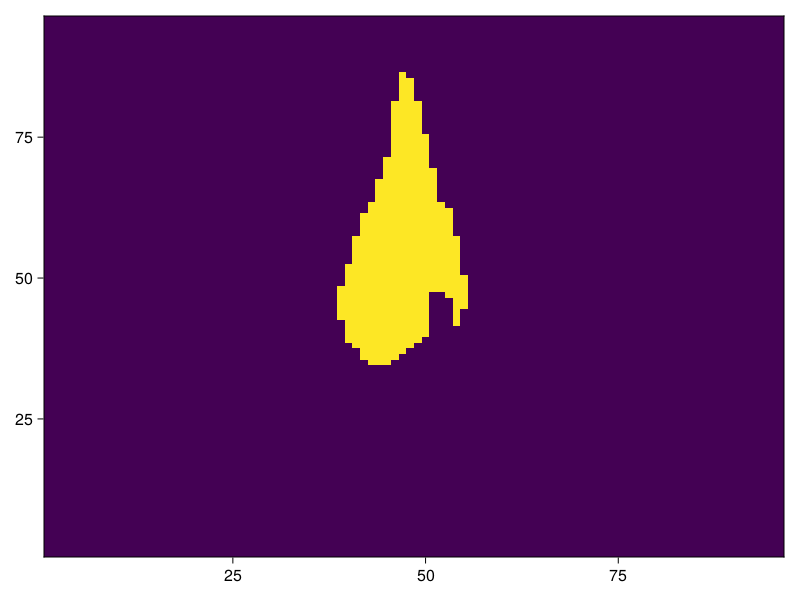

In [51]:
CairoMakie.heatmap(y1[43,:,:,1,1])

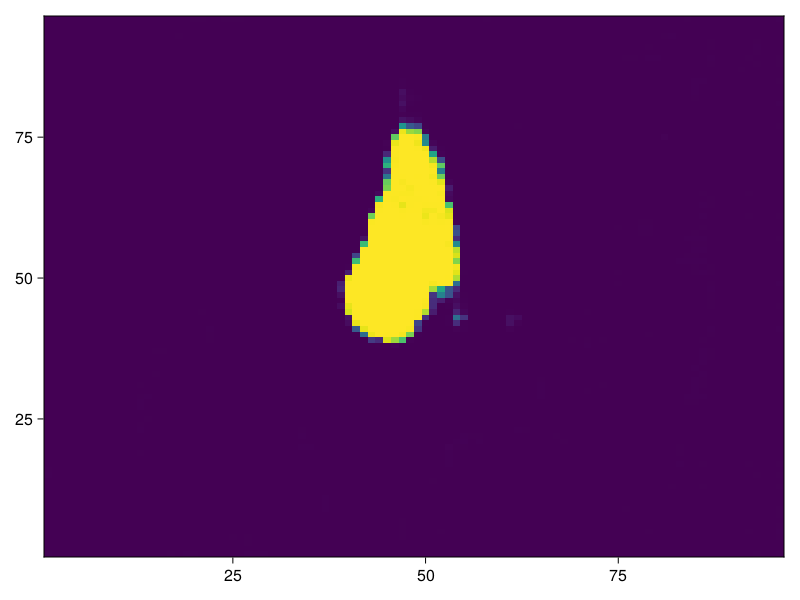

In [52]:
CairoMakie.heatmap(y_pred1[43,:,:,2,1])

In [47]:
# save 4 data
df_epoch = DataFrame(epoch_times_dice = epoch_times_dice, epoch_times_dice_hd = epoch_times_dice_hd)
CSV.write("Julia_Loop_Results/Epoch_Time_jan_8_2.csv", df_epoch)

"Julia_Loop_Results/Epoch_Time_jan_8_2.csv"

In [48]:
df_step = DataFrame(step_times_dice = step_times_dice, step_times_dice_hd = step_times_dice_hd)
CSV.write("Julia_Loop_Results/Step_Time_jan_8_2.csv", df_step)

"Julia_Loop_Results/Step_Time_jan_8_2.csv"

In [32]:
df_loss = DataFrame(train_losses_dice = epoch_train_losses_dice, train_losses_dice_hd = epoch_train_losses_dice_hd, 
valid_losses_dice = epoch_valid_losses_dice, valid_losses_dice_hd = epoch_valid_losses_dice_hd)
CSV.write("Julia_Loop_Results/Julia_Loop_Loss_jan_8.csv", df_loss)

"Julia_Loop_Results/Julia_Loop_Loss_jan_8.csv"

In [33]:
df_dice_m = DataFrame(train_dice_metric_dice = train_dice_metric_epoch_dice, valid_dice_metric_dice = valid_dice_metric_epoch_dice, 
all_dice_metric_dice = all_dice_metric_epoch_dice, train_dice_metric_dice_hd = train_dice_metric_epoch_dice_hd,
valid_dice_metric_dice_hd = valid_dice_metric_epoch_dice_hd, all_dice_metric_dice_hd = all_dice_metric_epoch_dice_hd)
CSV.write("Julia_Loop_Results/Julia_Loop_Dice_Metric_jan_8.csv", df_dice_m)

"Julia_Loop_Results/Julia_Loop_Dice_Metric_jan_8.csv"

In [34]:
df_hd_m = DataFrame(train_hd_metric_dice = train_hd_metric_epoch_dice, valid_hd_metric_dice = valid_hd_metric_epoch_dice, 
all_hd_metric_dice = all_hd_metric_epoch_dice, train_hd_metric_dice_hd = train_hd_metric_epoch_dice_hd,
valid_hd_metric_dice_hd = valid_hd_metric_epoch_dice_hd, all_hd_metric_dice_hd = all_hd_metric_epoch_dice_hd)
CSV.write("Julia_Loop_Results/Julia_Loop_HD_Metric_jan_8.csv", df_hd_m)

"Julia_Loop_Results/Julia_Loop_HD_Metric_jan_8.csv"

In [35]:
size(epoch_times_dice)

(250,)